# Import packages

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import torch
from torch.optim import Adam
import scipy.stats as stat
from scipy.stats import multivariate_normal
import sbi
import lsbi
from lsbi.network import BinaryClassifierLPop, BinaryClassifier
import math
import sys
import pickle
from datetime import datetime
import IPython
from concurrent.futures import ThreadPoolExecutor, TimeoutError
import time
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, HBox, VBox
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider
from torch import nn

# Extract data

In [2]:
De = pd.read_csv('/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv')


De_mass_list = De["Mass [GeV]"]
De_event_list = De["Events/10 GeV"]

De_mass = []
De_event = []

for i,elem in enumerate(De_mass_list):
    De_mass.append(De_mass_list[i])
    De_event.append(De_event_list[i])

De_mass = np.array(De_mass)
De_event = np.array(De_event)

yerr = np.sqrt(De_event)

# Plot curve

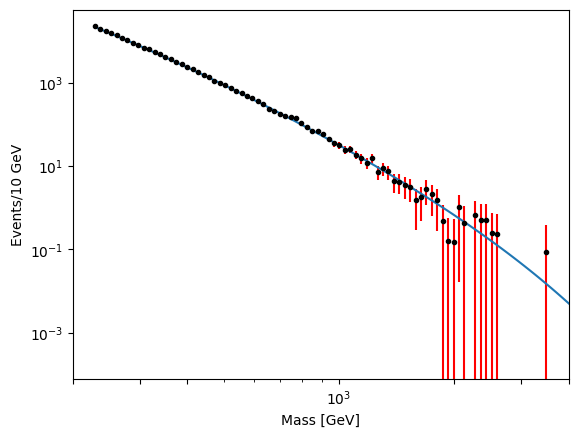

In [3]:
x_me = De_mass/13000
c_e = 1
a = 178000
b = 1.5
p0 = -12.38
p1 = -4.295
p2 = -0.9191
p3 = -0.0845
gamma = 2.4952
mz = 91.1876
# BW = (1/(2*np.pi)) + gamma/((De_mass - mz)**2 + (gamma**2)/4)
# BW1 = 1/((De_mass - mz)**2 + (gamma**2)/4)
BW2 = gamma / ((x_me*13000 - mz) ** 2 + gamma**2 / 4)

# curve = 178000/(np.trapz(De_event, De_mass)) * BW * ((1-x**(c_e))**b) * x ** (p0*(np.log10(x))**0 + p1*(np.log10(x)**1) + p2*(np.log10(x)**2) + p3*(np.log10(x))**3)
curve = BW2 * ((1-x_me**(c_e))**b) * x_me ** (p0*(np.log(x_me))**0 + p1*(np.log(x_me)**1) + p2*(np.log(x_me)**2) + p3*(np.log(x_me)**3))
norm = a/curve.sum(axis=-1)
curve1 = norm*curve
# print(f"{np.sum(De_event)}")

plt.errorbar(De_mass, De_event, yerr = yerr, fmt = '.', color = 'black', ecolor = 'red')
plt.plot(De_mass, curve1)
plt.xlim(0,4000)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Mass [GeV]")
plt.ylabel("Events/10 GeV")
plt.xlim(200, 4000)
plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
plt.show()

# Scipy optimisation

/var/folders/rw/0z5hx32j3mj7xfk6t229lqy40000gn/T/ipykernel_87764/895002134.py:8: RuntimeWarning: overflow encountered in power
  curve_f = BW2 * ((1 - x_f) ** b_f) * x_f ** (p0_f + p1_f * np.log(x_f) + p2_f * np.log(x_f) ** 2 + p3_f * np.log(x_f) ** 3)
/var/folders/rw/0z5hx32j3mj7xfk6t229lqy40000gn/T/ipykernel_87764/895002134.py:9: RuntimeWarning: invalid value encountered in multiply
  return a_f/curve_f.sum(axis=-1) * curve_f
/var/folders/rw/0z5hx32j3mj7xfk6t229lqy40000gn/T/ipykernel_87764/895002134.py:8: RuntimeWarning: overflow encountered in multiply
  curve_f = BW2 * ((1 - x_f) ** b_f) * x_f ** (p0_f + p1_f * np.log(x_f) + p2_f * np.log(x_f) ** 2 + p3_f * np.log(x_f) ** 3)


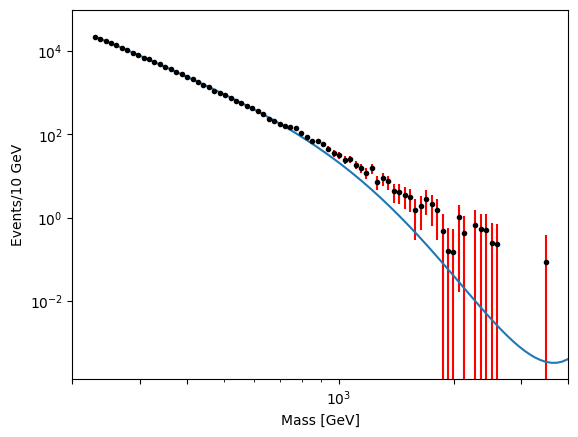

Model: a * ((1-x**(c))**b) * x ** (p0*(np.log10(x))**0 + p1_f*(np.log10(x)**1) + p2_f*(np.log10(x)**2) + p3_f*(np.log10(x))**3) 
a = 183563.3882981821, b = -272.04303689335853, 
p0 = -288.1877448996009, p1 = -100.43272577076249, p2 = -16.53788251595986, p3 = -1.0662191441905193


In [5]:
#@title Optimise all parameters

popt = [178000, 1.5, -12.38, -4.295, -0.9191, -0.0845]

# Define your fitting function without the normalization dependent on 'a_f'
def funcP2(x_f, a_f, b_f, p0_f, p1_f, p2_f, p3_f):
    BW2 = gamma / ((x_f * 13000 - mz) ** 2 * (gamma ** 2 / 4))
    curve_f = BW2 * ((1 - x_f) ** b_f) * x_f ** (p0_f + p1_f * np.log(x_f) + p2_f * np.log(x_f) ** 2 + p3_f * np.log(x_f) ** 3)
    return a_f/curve_f.sum(axis=-1) * curve_f

# Perform the curve fitting
poptP2, pcovP2 = curve_fit(funcP2, x_me, De_event, popt, maxfev=100000)

plt.errorbar(De_mass, De_event, yerr = yerr, fmt = '.', color = 'black', ecolor = 'red')
plt.plot(np.array(De_mass), funcP2(np.array(x_me), *poptP2))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Mass [GeV]")
plt.ylabel("Events/10 GeV")
plt.xlim(200, 4000)
plt.ylim(top = 10**5)
plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
plt.show()

print(f"Model: a * ((1-x**(c))**b) * x ** (p0*(np.log10(x))**0 + p1_f*(np.log10(x)**1) + p2_f*(np.log10(x)**2) + p3_f*(np.log10(x))**3) \n"
f"a = {poptP2[0]}, b = {poptP2[1]}, \n"
f"p0 = {poptP2[2]}, p1 = {poptP2[3]}, p2 = {poptP2[4]}, p3 = {poptP2[5]}")

# AIC for 3 vs 4 (Check if correct)

In [7]:
#@title Information criteria

#Comparing AIC for i = 3 model and i = 4 model from above

AIC3 = 2*3 - 2*(-losses_3_init[-1]/2)
AIC4 = 2*4 - 2*(-losses_4_init[-1]/2)

print(f"AIC for 3 = {AIC3}, AIC for 4 = {AIC4} \n"
"AIC for 4 is slightly lower so more favourable \n"
f"% Difference in AIC = {100*np.abs((AIC3 - AIC4))/AIC4} \n"
"This difference is low. i = 3 is slghtly more favourable")

AIC for 3 = 8.879819727890762, AIC for 4 = 10.911882052012462 
AIC for 4 is slightly lower so more favourable 
% Difference in AIC = 18.622473322527615 
This difference is low. i = 3 is slghtly more favourable


# Note: Check AIC is correct

# Torch optimisation from AGNOSTIC prior distribution i = 2

In [322]:
### Sped up version of class but now for fixd abp0

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p2:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95], high=[1.9 * 10**5, 5, -11.5, -4, -0.45])

    def curve_torch_2(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 100

    def adjust_theta_2(self, y_pred_2):
        loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_2

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 10000
            loss_crit = 1.5
            loss_filter = 1.4
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 7000 and loss > loss_filter:
                    print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            plt.plot(De_mass, y_pred_2_plot)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 4000)
            plt.ylim(top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            plt.show()

            f_loss,a_loss = plt.subplots()
            a_loss.plot(losses)
            # a_loss.set_yscale("log")
            a_loss.set_ylabel("Loss")
            a_loss.set_xlabel("Iteration")
            # a_loss.set_xlim(N_iter-1000, N_iter)
            # a_loss.set_ylim(0.55, 0.6)


# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

optimizer_class = optim_p2(data_path)
optimizer_class.run()

Initial Loss = 78.238037109375
Final loss before filter = 8.46227741241455
Initial Loss = 79.39456176757812
Final loss before filter = 8.036694526672363
Initial Loss = 75.10839080810547
Final loss before filter = 3.7371742725372314
Initial Loss = 93.70457458496094


KeyboardInterrupt: 

# Torch optimisation from AGNOSTIC prior distributions i = 3

Initial Loss = 10.645217895507812
Final theta = tensor([ 1.8370e+05,  4.7131e+00, -1.1395e+01, -4.1092e+00, -9.1318e-01,
        -8.5580e-02]), Final loss = 0.5597954392433167, Number of iterations = 1400


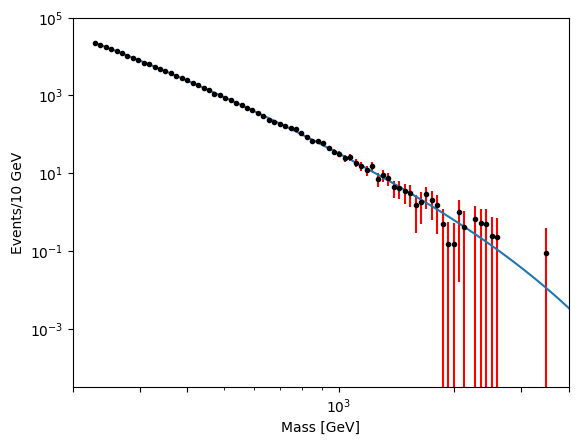

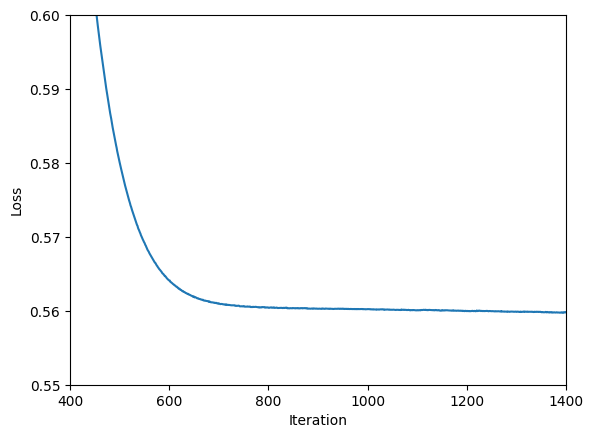

In [5]:
### Sped up version of class but now for fixd abp0

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 100

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 0.6
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            plt.plot(De_mass, y_pred_3_plot)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 4000)
            plt.ylim(top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            plt.show()

            f_loss,a_loss = plt.subplots()
            a_loss.plot(losses)
            # a_loss.set_yscale("log")
            a_loss.set_ylabel("Loss")
            a_loss.set_xlabel("Iteration")
            a_loss.set_xlim(N_iter-1000, N_iter)
            a_loss.set_ylim(0.55, 0.6)


# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

optimizer_class = optim_p3(data_path)
optimizer_class.run()

# Torch optimisation from AGNOSTIC prior distributions i = 4

Initial Loss = 8.192639350891113
Initial Loss = 14.173677444458008
Initial Loss = 22.5822696685791
Loss at 1000 iterations = 0.5754052996635437
Loss at 1500 iterations = 0.5747957825660706
Final theta = tensor([ 1.8352e+05,  1.0682e+00, -1.3031e+01, -3.9458e+00, -7.0805e-01,
        -5.1112e-02,  1.4151e-03]), Final loss = 0.5625650882720947, Number of iterations = 9950


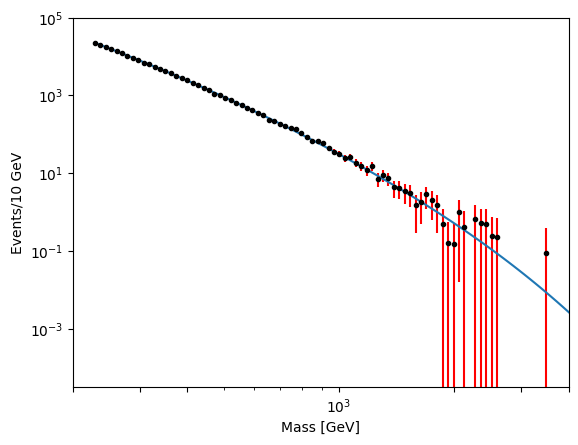

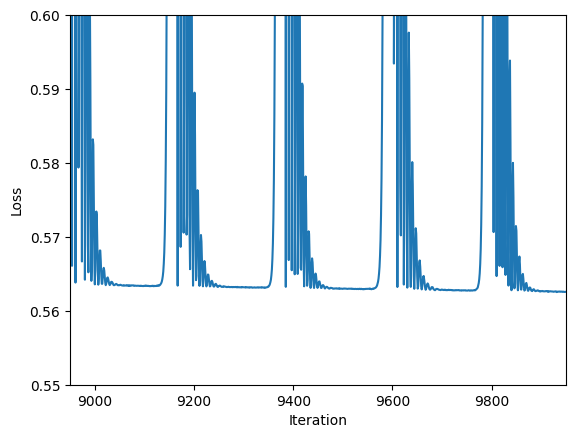

In [126]:
### Sped up version of class but now for fixd abp0

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p4:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04, -0.001])

    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 9950
            loss_crit = 1.5
            loss_filter = 0.6
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                if N_iter == 1000 and loss < loss_filter:
                    print(f"Loss at 1000 iterations = {loss}")
                if N_iter == 1500 and loss < loss_filter:
                    print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:
            
            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            y_pred_4_plot = self.curve_torch_4(self.x_tensor, *theta_final).detach().numpy()
            plt.plot(De_mass, y_pred_4_plot)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 4000)
            plt.ylim(top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            plt.show()

            f_loss,a_loss = plt.subplots()
            a_loss.plot(losses)
            # a_loss.set_yscale("log")
            a_loss.set_ylabel("Loss")
            a_loss.set_xlabel("Iteration")
            a_loss.set_xlim(N_iter-1000, N_iter)
            a_loss.set_ylim(0.55, 0.6)


# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

optimizer_class = optim_p4(data_path)
optimizer_class.run()

# Narrowing priors (regular optimise other values)

Manually narrowed priors down to ranges:

a: 1.6 to 1.8 * 10**5 (Using fact that must be equal to number of events)

b: 1 to 5 (using Desmos and plotting loglike against p (with fixed a and p0, 180000 and -12, no other parameters)

p0: -10 to -15 (Desmos)

p1: -3.5 to -5.2 (Desmos)

p2: -0.45 to -1

p3: -0.1 to -0.045

p4: -0.001 to -0.006

Should also check if b 1 to 10 looks reasonable (for all other priors in same ranges, range of other priors shouldnt affect allowed values of b since b only finely adjusts and that too the tail)

Results of narrowing down using the code below shows that p0 can be cut down to at least -11 to -14, and potentially -11 to -13.5 (maybe even further, repeat many times and check)

Check what it suggests about b

After narrowing:

Should check what gradient values look like on same scatter plot at values close to low loglike points ie. within +/- 0.5 of loglike critical, plot in different colour

## b vs p0 (regular optimise other values)

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[0, 5]
Calculated loglike_values[0, 6]
Calculated loglike_values[0, 7]
Calculated loglike_values[0, 8]
Calculated loglike_values[0, 9]
Calculated loglike_values[0, 10]
Calculated loglike_values[0, 11]
Calculated loglike_values[0, 12]
Calculated loglike_values[0, 13]
Calculated loglike_values[0, 14]
Calculated loglike_values[0, 15]
Calculated loglike_values[0, 16]
Calculated loglike_values[0, 17]
Calculated loglike_values[0, 18]
Calculated loglike_values[0, 19]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[1, 5]
Calculated loglike_values[1, 6]
Calculated loglike_values[1, 7]
Calculated loglike_values[1, 8]
Calculated loglike_values[1, 9]
Calculated loglike_values[1, 1

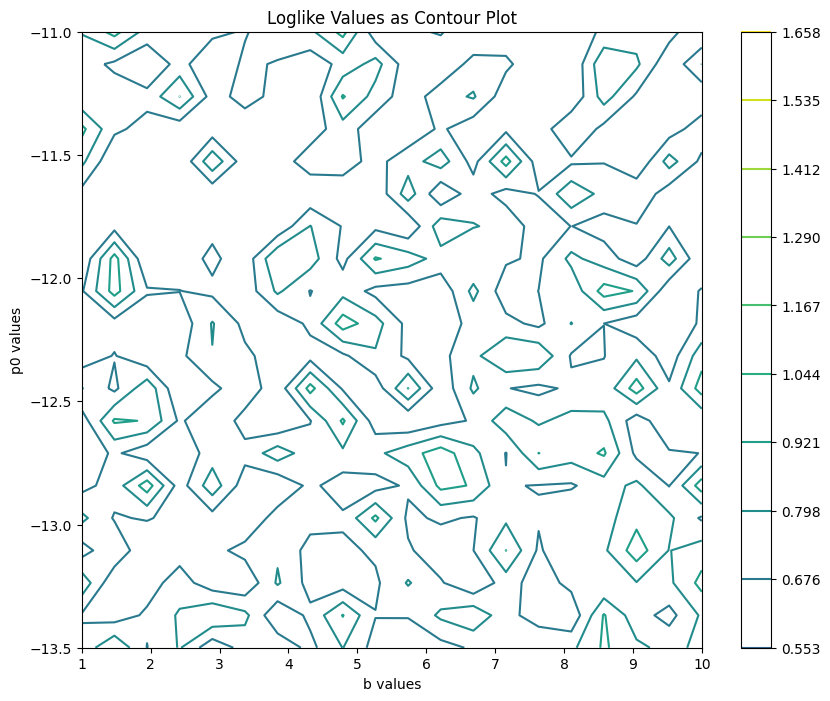

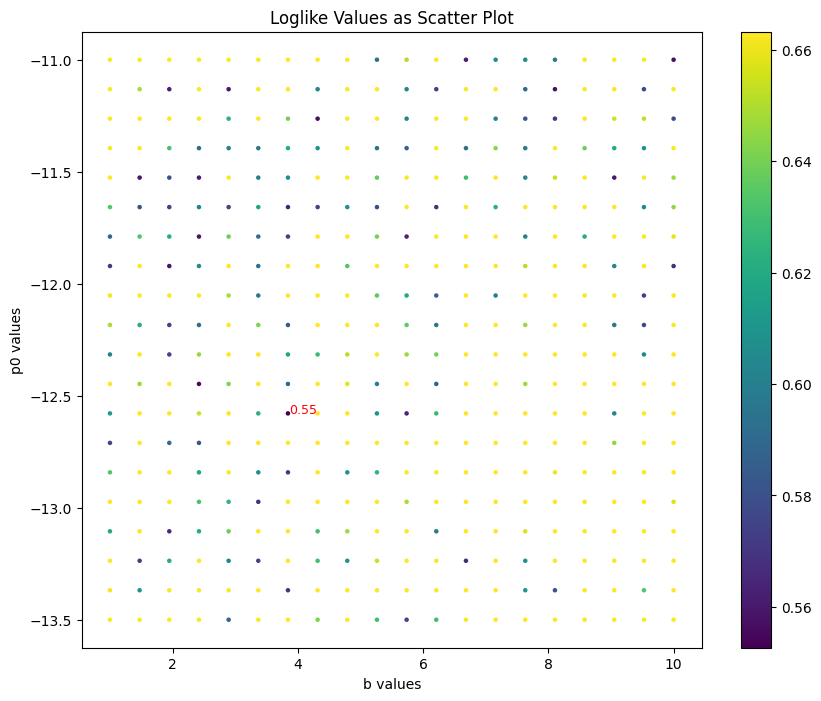

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[0, 5]
Calculated loglike_values[0, 6]
Calculated loglike_values[0, 7]
Calculated loglike_values[0, 8]
Calculated loglike_values[0, 9]
Calculated loglike_values[0, 10]
Calculated loglike_values[0, 11]
Calculated loglike_values[0, 12]
Calculated loglike_values[0, 13]
Calculated loglike_values[0, 14]
Calculated loglike_values[0, 15]
Calculated loglike_values[0, 16]
Calculated loglike_values[0, 17]
Calculated loglike_values[0, 18]
Calculated loglike_values[0, 19]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[1, 5]
Calculated loglike_values[1, 6]
Calculated loglike_values[1, 7]
Calculated loglike_values[1, 8]
Calculated loglike_values[1, 9]
Calculated loglike_values[1, 1

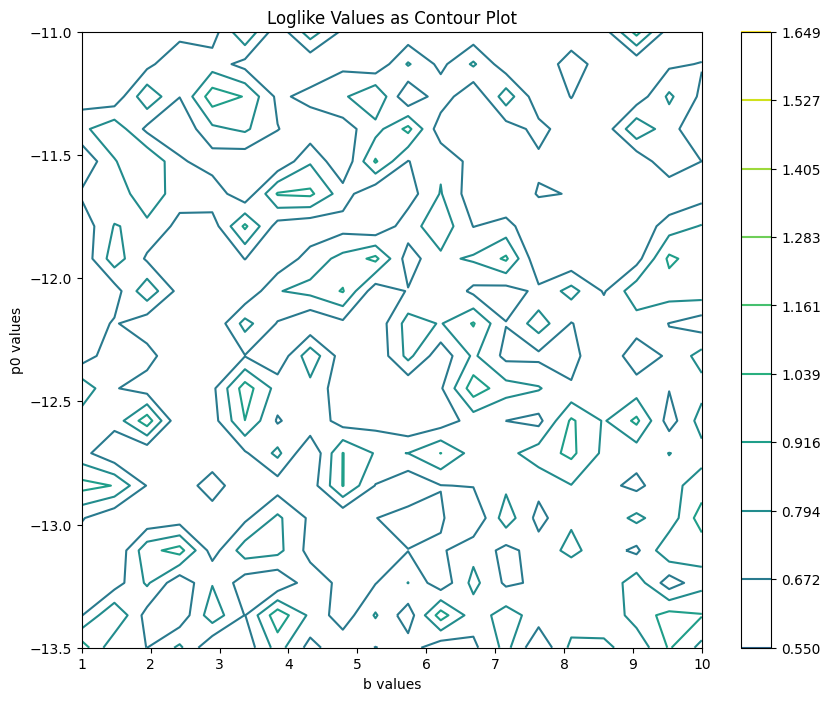

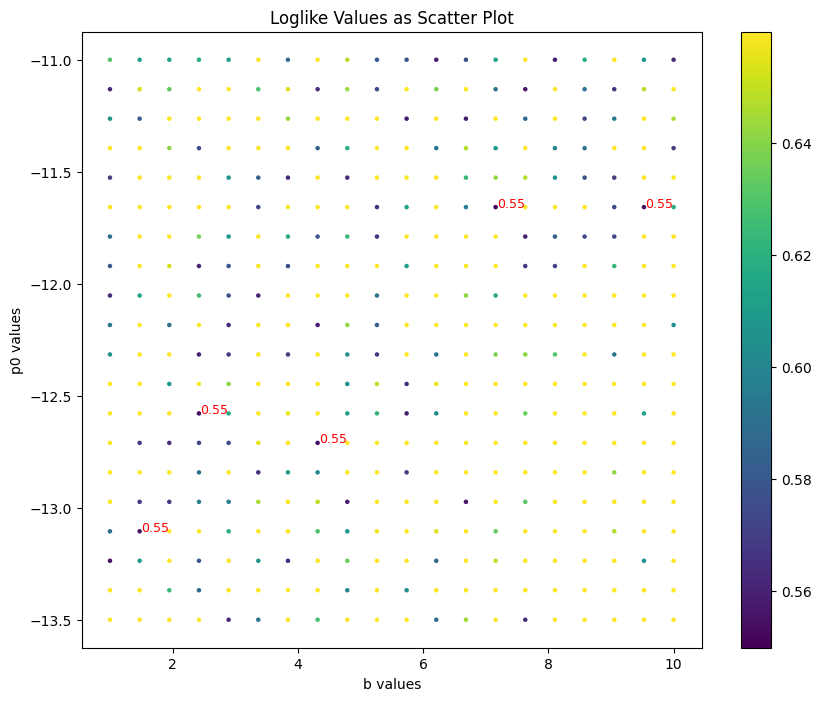

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[0, 5]
Calculated loglike_values[0, 6]
Calculated loglike_values[0, 7]
Calculated loglike_values[0, 8]
Calculated loglike_values[0, 9]
Calculated loglike_values[0, 10]
Calculated loglike_values[0, 11]
Calculated loglike_values[0, 12]
Calculated loglike_values[0, 13]
Calculated loglike_values[0, 14]
Calculated loglike_values[0, 15]
Calculated loglike_values[0, 16]
Calculated loglike_values[0, 17]
Calculated loglike_values[0, 18]
Calculated loglike_values[0, 19]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[1, 5]
Calculated loglike_values[1, 6]
Calculated loglike_values[1, 7]
Calculated loglike_values[1, 8]
Calculated loglike_values[1, 9]
Calculated loglike_values[1, 1

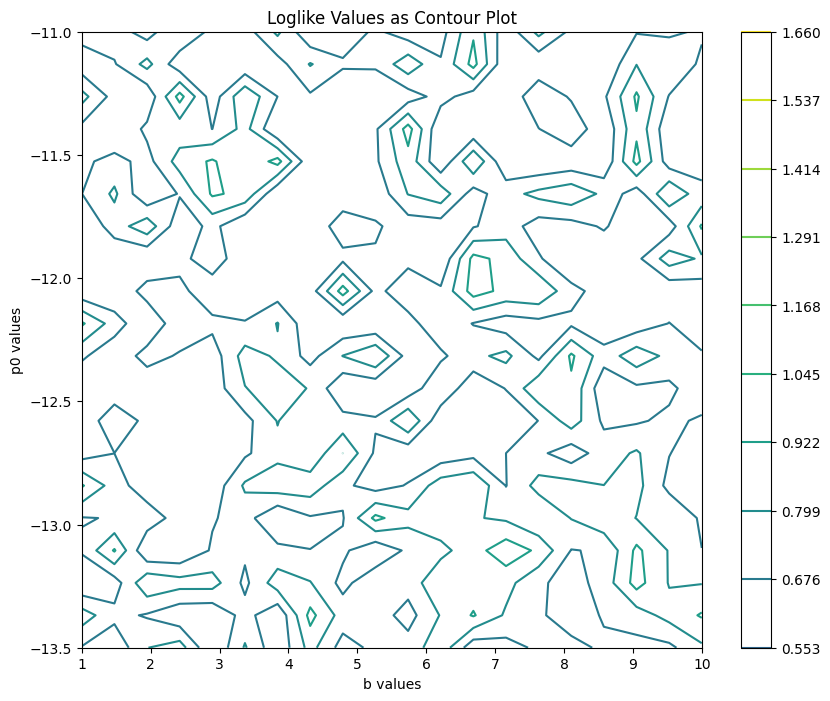

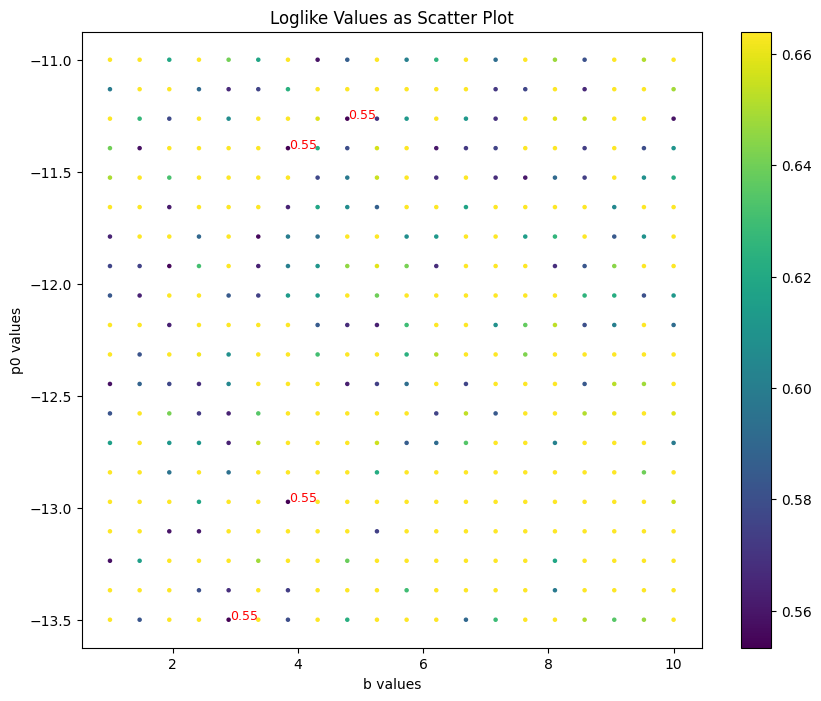

In [287]:
### Sped up version of class but now for fixed abp0

# Fix b and p0

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3_fix_bp0:
    def __init__(self, data_path, constant_b, constant_p0):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p0 = constant_p0

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, self.constant_p0, -5.2, -0.95, -0.1], high=[1.9 * 10**5, self.constant_b, self.constant_p0, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 50

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i >= 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i >= 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 5
            loss_filter = 1
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 500 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta[i])
                if i >= 3:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

            # print(f"Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")

            # Plot results (ONLY NEED THIS FOR TORCH OPT i = 3 to plot result of each opt, not if opting for each b and p0 value)

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # a_loss.set_xlim(N_iter-1000, N_iter)
            # a_loss.set_ylim(0.55, 0.6)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_b_p0():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 10 # Real is 1 Viewing is 
    p0_ft_lower = -13.5 # Real is -15 Viewing is -20
    p0_ft_upper = -11 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p0_ft_values = torch.linspace(p0_ft_lower, p0_ft_upper, 20)
    B, P0 = torch.meshgrid(b_ft_values, p0_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p1_ft_values = torch.zeros(B.shape)
    p2_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp0(data_path, b_ft_values[i], p0_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], b_ft_values[i], p0_ft_values[j], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p1_ft_values[i, j] = theta_final[3]
            p2_ft_values[i, j] = theta_final[4]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(b_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[j].item())
                p1_values_array.append(p1_ft_values[i, j].item())
                p2_values_array.append(p2_ft_values[i, j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history')

    # # Save file with gradients

    # def save_loglike_values(loglike_values, b_ft_values, p0_ft_values, loglike_b_gradients, loglike_p0_gradients, filename_prefix='loglike_history'):
    #     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    #     filename = f"{filename_prefix}_{timestamp}.csv"
        
    #     loglike_values = loglike_values.detach().numpy()

    #     b_values_array = []
    #     p0_values_array = []
    #     loglike_values_array = []
    #     loglike_b_gradients_array = []
    #     loglike_p0_gradients_array = []
    
    #     for i in range(len(b_ft_values)):
    #         for j in range((len(b_ft_values))):
    #             b_values_array.append(b_ft_values[i].item())
    #             p0_values_array.append(p0_ft_values[j].item())
    #             loglike_values_array.append(loglike_values[i, j].item())
    #             loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
    #             loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    #     b_values_array = np.array(b_values_array)
    #     p0_values_array = np.array(p0_values_array)
    #     loglike_values_array = np.array(loglike_values_array)
    #     loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    #     loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    #     # Create a DataFrame with appropriate headers
    #     df = pd.DataFrame({
    #         'b_values': b_values_array,
    #         'p0_values': p0_values_array,
    #         'loglikelihood': loglike_values_array,
    #         'loglike b grad': loglike_b_gradients_array,
    #         'loglike p0 grad': loglike_p0_gradients_array,
    #     })

    #     # Save the DataFrame to a new CSV file with headers
    #     df.to_csv(filename, index=False)
    #     print(f"Data saved to {filename}")

    # save_loglike_values(loglike_values, b_ft_values, p0_ft_values, loglike_b_gradients, loglike_p0_gradients, filename_prefix='loglike_history')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P0.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[j].item())
            p1_values_array.append(p1_ft_values[i, j].item())
            p2_values_array.append(p2_ft_values[i, j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p0_values_array = np.array(p0_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.555

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
for i in range(3):
    contour_plot_b_p0()

## Replot b vs p0

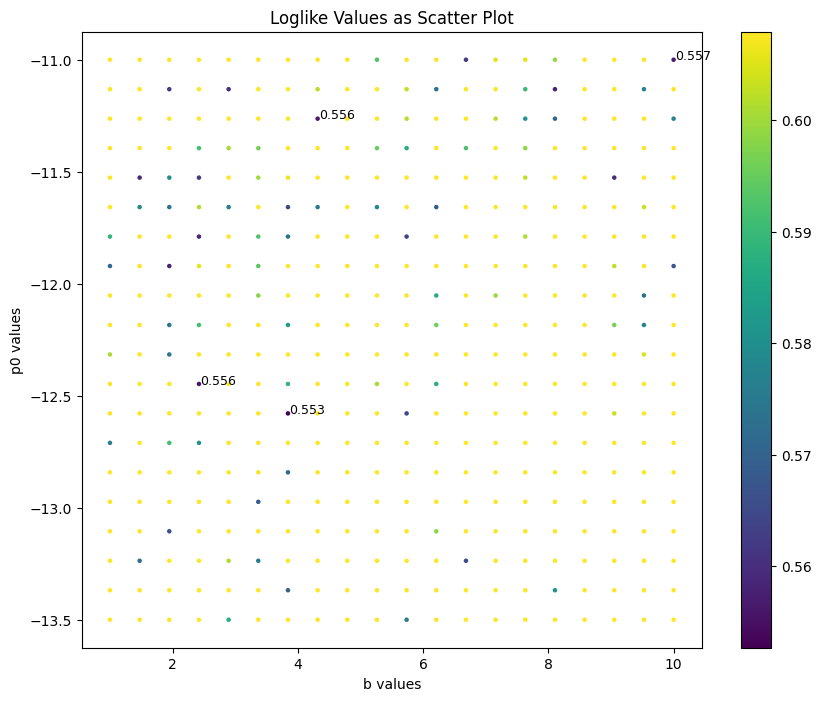

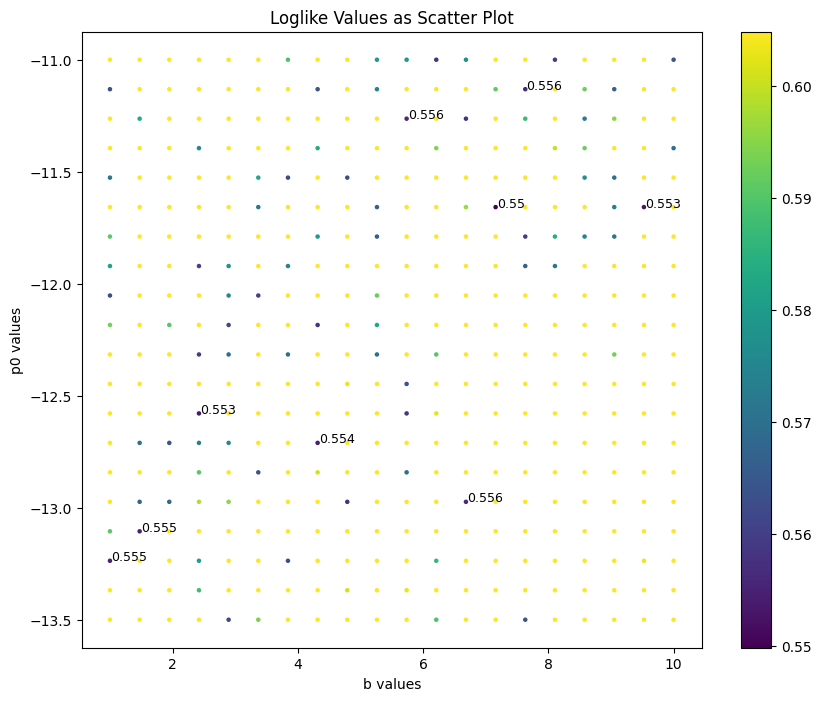

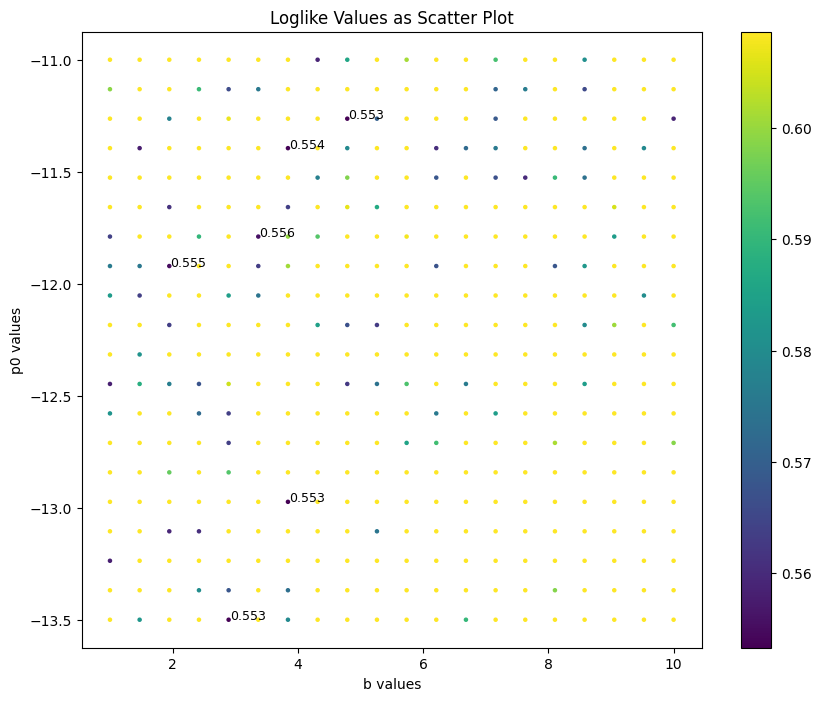

In [295]:
# Plotting results

def replot_scatter_b_p0(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.1)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.557

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_values_array[i], 3)), fontsize=9, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

# replot_scatter('loglike_history_20240307_063726_narrow_big_data.csv')
    
# replot_scatter('loglike_history_20240310_214317_all_params_2.csv')
    
# replot_scatter_b_p0('loglike_history_20240314_112350.csv') b 5 to 10

replot_scatter_b_p0('loglike_history_20240314_114139.csv') # b 1 to 10 repeat 1
replot_scatter_b_p0('loglike_history_20240314_114947.csv') # b 1 to 10 repeat 2
replot_scatter_b_p0('loglike_history_20240314_115737.csv') # b 1 to 10 repeat 3
    


# replot_scatter('loglike_history_20240306_194817_narrrow_w_new_ranges.csv')
# replot_scatter('loglike_history_20240306_200623_narrow_w_new_ranges_2.csv')
# replot_scatter('loglike_history_20240306_201303_narrow_w_new_ranges_3.csv')
# replot_scatter('loglike_history_20240306_204230_narrow_w_new_ranges_4.csv')
# replot_scatter('loglike_history_20240306_204924_narrow_w_new_ranges_5.csv')

## b vs p1 (regular optimise other values)

Initial Loss = 46.41084671020508
Calculated loglike_values[0, 0]
Initial Loss = 46.49187088012695
Calculated loglike_values[0, 1]
Initial Loss = 45.98826217651367
Calculated loglike_values[0, 2]
Initial Loss = 16.42168617248535
Calculated loglike_values[0, 3]
Initial Loss = 41.863555908203125
Calculated loglike_values[0, 4]
Initial Loss = 28.700342178344727
Calculated loglike_values[0, 5]
Initial Loss = 36.211143493652344
Calculated loglike_values[0, 6]
Initial Loss = 44.932586669921875
Initial Loss = 41.628028869628906
Initial Loss = 17.326040267944336
Calculated loglike_values[0, 7]
Initial Loss = 16.678625106811523
Calculated loglike_values[0, 8]
Initial Loss = 29.964330673217773
Calculated loglike_values[0, 9]
Initial Loss = 22.42746353149414
Calculated loglike_values[0, 10]
Initial Loss = 18.752033233642578
Calculated loglike_values[0, 11]
Initial Loss = 12.553470611572266
Calculated loglike_values[0, 12]
Initial Loss = 3.325533151626587
Calculated loglike_values[0, 13]
Initial Lo

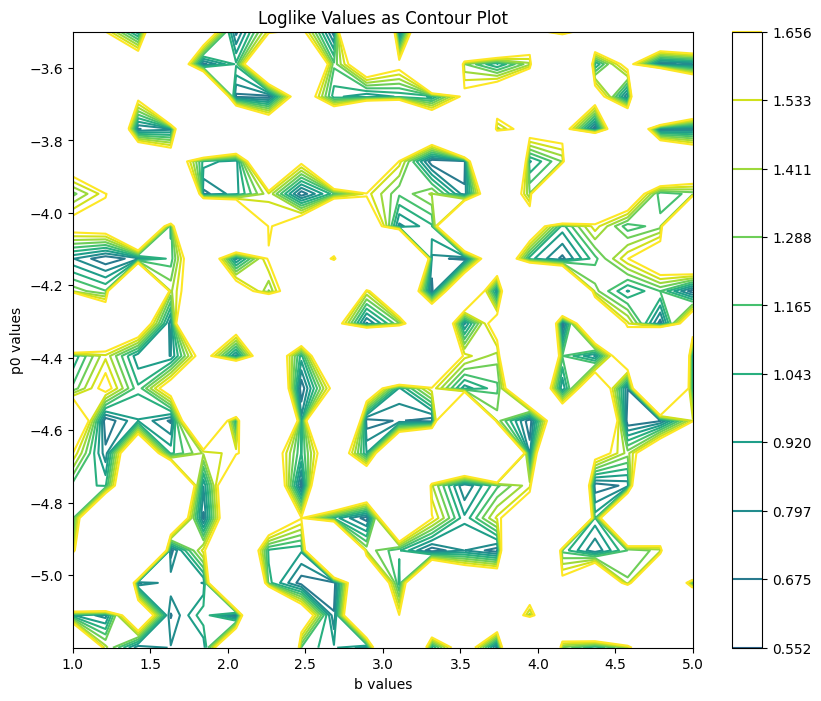

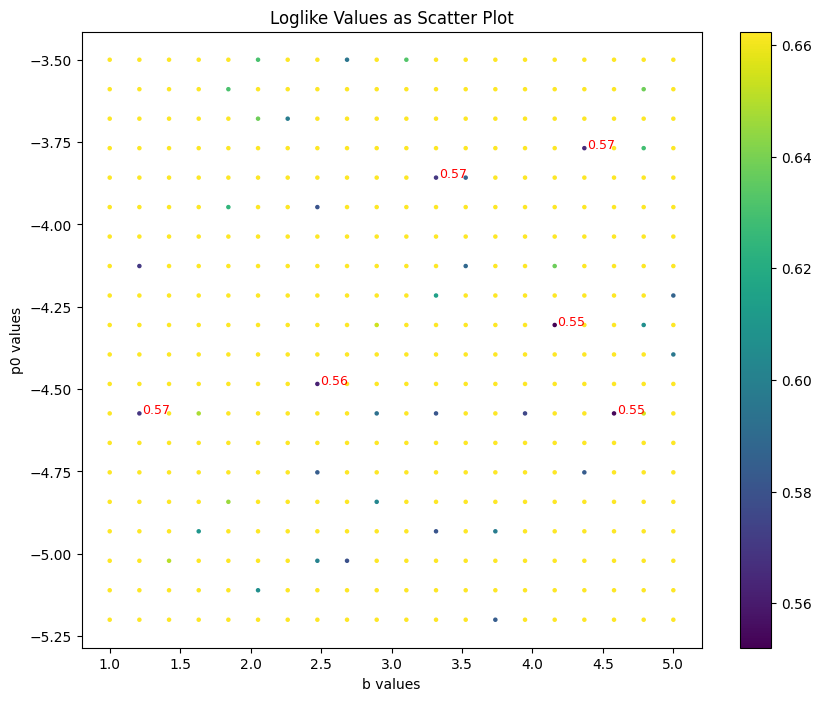

Initial Loss = 48.480892181396484
Calculated loglike_values[0, 0]
Initial Loss = 48.059234619140625
Initial Loss = 40.803466796875
Calculated loglike_values[0, 1]
Initial Loss = 37.470375061035156
Calculated loglike_values[0, 2]
Initial Loss = 49.295379638671875
Calculated loglike_values[0, 3]
Initial Loss = 45.07386016845703
Calculated loglike_values[0, 4]
Initial Loss = 41.743473052978516
Calculated loglike_values[0, 5]
Initial Loss = 42.230655670166016
Calculated loglike_values[0, 6]
Initial Loss = 26.690095901489258
Initial Loss = 13.00488567352295
Calculated loglike_values[0, 7]
Initial Loss = 20.635665893554688
Calculated loglike_values[0, 8]
Initial Loss = 25.40806007385254
Calculated loglike_values[0, 9]
Initial Loss = 17.295190811157227
Calculated loglike_values[0, 10]
Initial Loss = 9.424112319946289
Calculated loglike_values[0, 11]
Initial Loss = 32.1491584777832
Calculated loglike_values[0, 12]
Initial Loss = 9.933743476867676
Calculated loglike_values[0, 13]
Initial Loss =

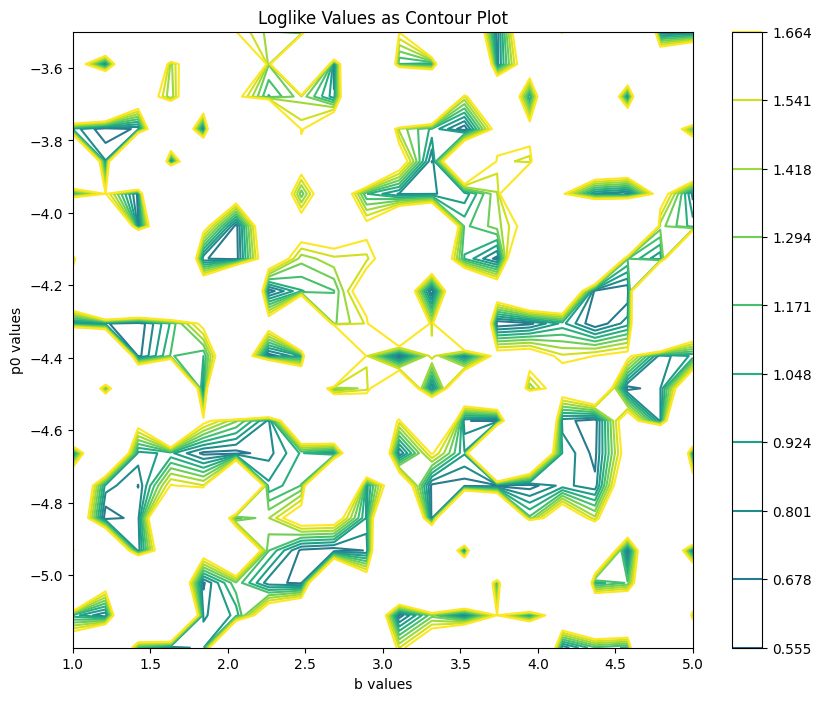

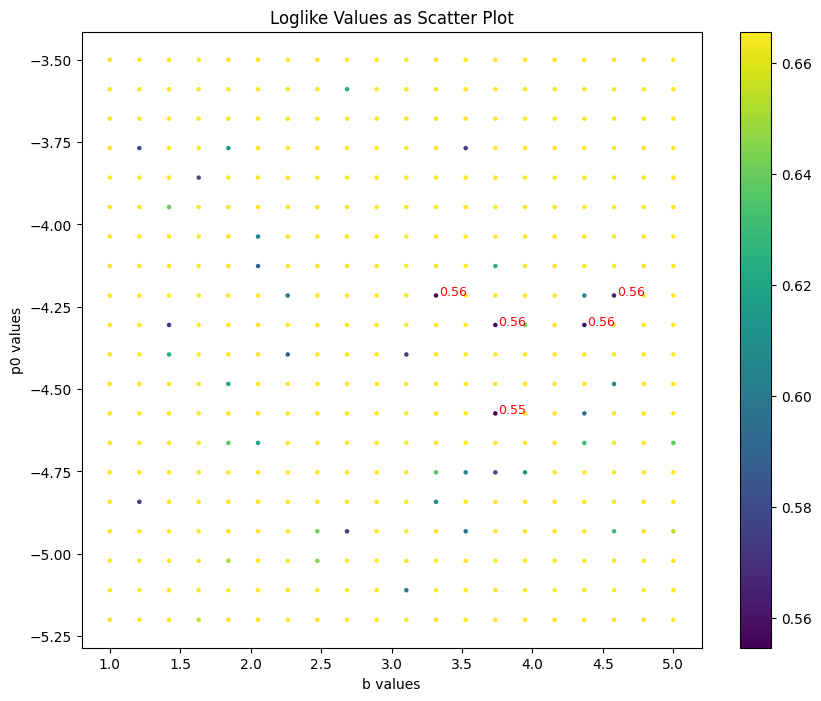

Initial Loss = 48.527671813964844
Calculated loglike_values[0, 0]
Initial Loss = 40.95494079589844
Calculated loglike_values[0, 1]
Initial Loss = 45.435142517089844
Calculated loglike_values[0, 2]
Initial Loss = 33.738250732421875
Calculated loglike_values[0, 3]
Initial Loss = 39.57737731933594
Calculated loglike_values[0, 4]
Initial Loss = 32.00043869018555
Initial Loss = 32.85865783691406
Calculated loglike_values[0, 5]
Initial Loss = 14.797337532043457
Calculated loglike_values[0, 6]
Initial Loss = 42.73011779785156
Initial Loss = 17.1844482421875
Calculated loglike_values[0, 7]
Initial Loss = 26.865598678588867
Calculated loglike_values[0, 8]
Initial Loss = 11.514995574951172
Calculated loglike_values[0, 9]
Initial Loss = 8.602182388305664
Calculated loglike_values[0, 10]
Initial Loss = 17.26779556274414
Initial Loss = 6.441192626953125
Calculated loglike_values[0, 11]
Initial Loss = 5.138998508453369
Calculated loglike_values[0, 12]
Initial Loss = 37.03357696533203
Calculated logl

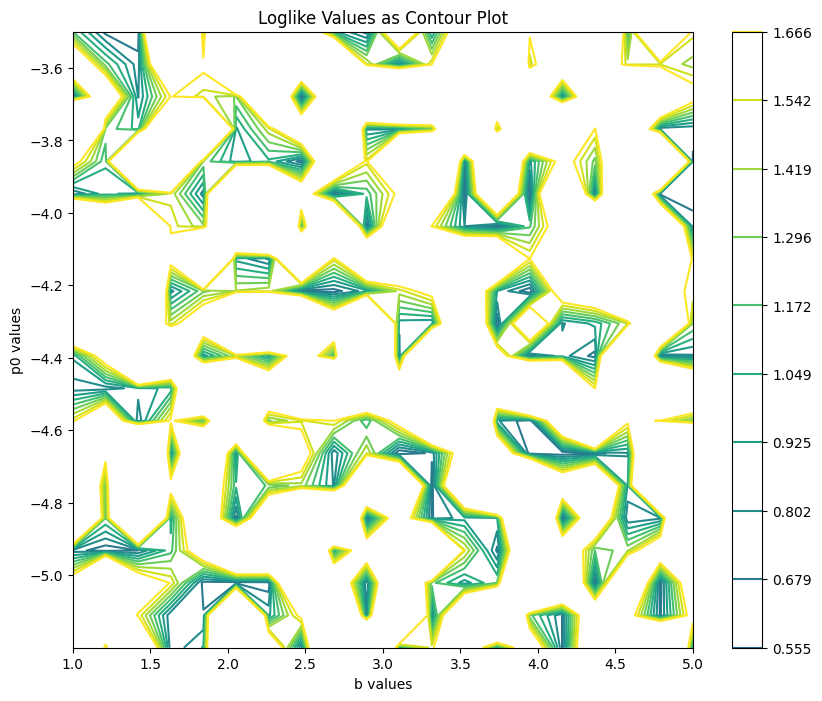

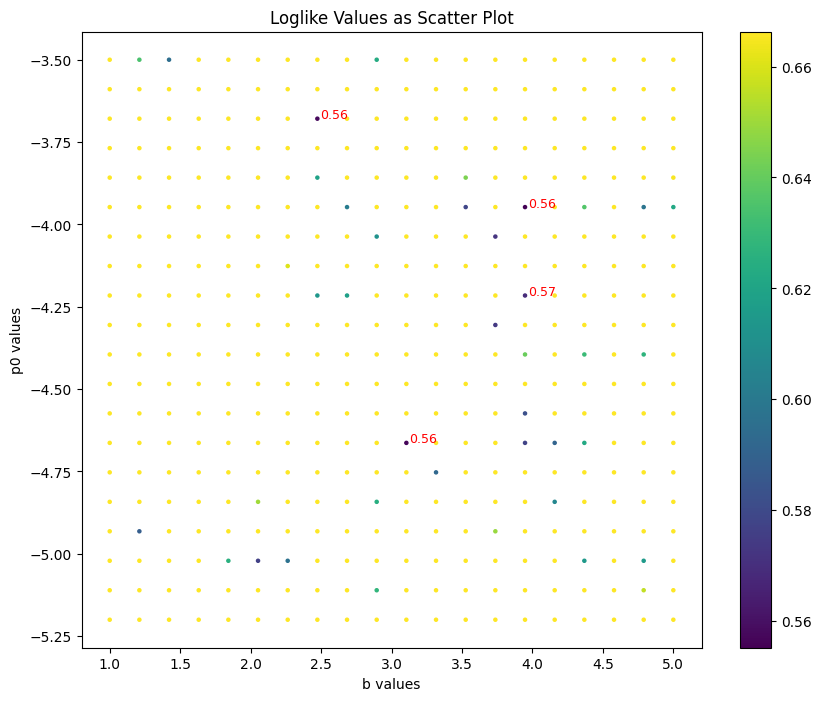

Initial Loss = 44.6196403503418
Calculated loglike_values[0, 0]
Initial Loss = 43.64582824707031
Calculated loglike_values[0, 1]
Initial Loss = 34.50363540649414
Calculated loglike_values[0, 2]
Initial Loss = 32.6497688293457
Initial Loss = 37.147125244140625
Initial Loss = 29.915714263916016
Calculated loglike_values[0, 3]
Initial Loss = 15.547318458557129
Calculated loglike_values[0, 4]
Initial Loss = 41.56167221069336
Calculated loglike_values[0, 5]
Initial Loss = 19.662710189819336
Calculated loglike_values[0, 6]
Initial Loss = 21.009382247924805
Calculated loglike_values[0, 7]
Initial Loss = 9.827079772949219
Calculated loglike_values[0, 8]
Initial Loss = 15.952392578125
Calculated loglike_values[0, 9]
Initial Loss = 44.94342803955078
Initial Loss = 6.5253777503967285
Calculated loglike_values[0, 10]
Initial Loss = 42.001338958740234
Calculated loglike_values[0, 11]
Initial Loss = 39.96892166137695
Calculated loglike_values[0, 12]
Initial Loss = 15.74584674835205
Calculated loglik

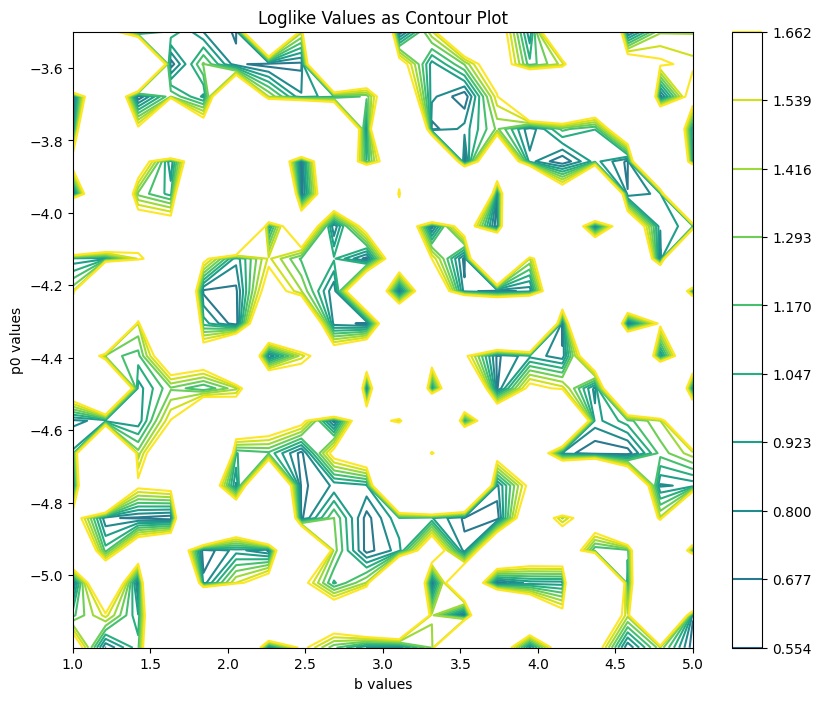

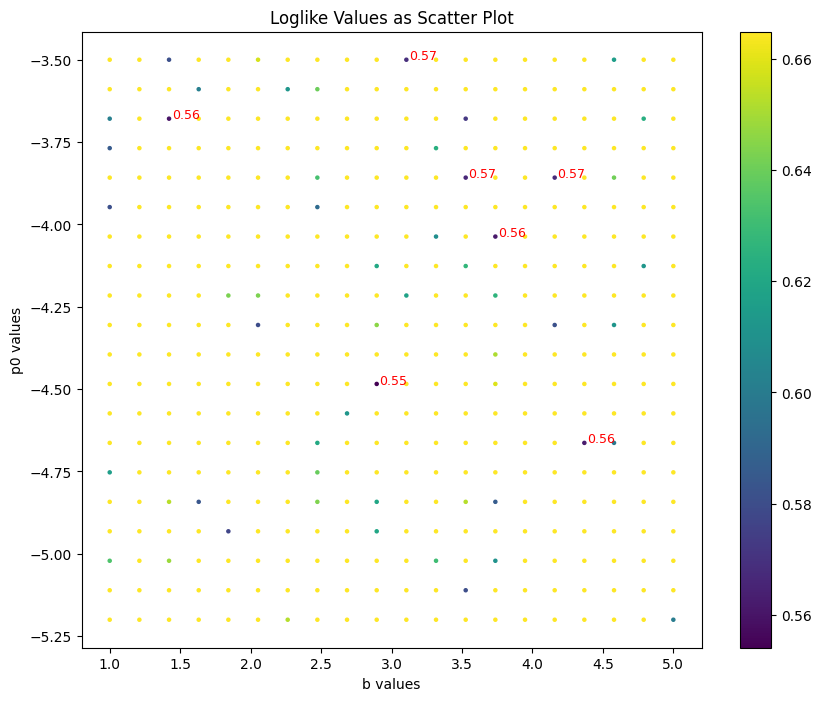

Initial Loss = 44.135581970214844
Calculated loglike_values[0, 0]
Initial Loss = 47.52079772949219
Calculated loglike_values[0, 1]
Initial Loss = 47.500396728515625
Calculated loglike_values[0, 2]
Initial Loss = 45.637264251708984
Calculated loglike_values[0, 3]
Initial Loss = 26.969196319580078
Calculated loglike_values[0, 4]
Initial Loss = 41.67530059814453
Calculated loglike_values[0, 5]
Initial Loss = 41.431182861328125
Calculated loglike_values[0, 6]
Initial Loss = 19.82416343688965
Calculated loglike_values[0, 7]
Initial Loss = 39.94614791870117
Calculated loglike_values[0, 8]
Initial Loss = 11.081881523132324
Calculated loglike_values[0, 9]
Initial Loss = 22.595699310302734
Calculated loglike_values[0, 10]
Initial Loss = 4.437307834625244
Calculated loglike_values[0, 11]
Initial Loss = 21.54233169555664
Calculated loglike_values[0, 12]
Initial Loss = 29.5043888092041
Calculated loglike_values[0, 13]
Initial Loss = 35.124759674072266
Calculated loglike_values[0, 14]
Initial Loss 

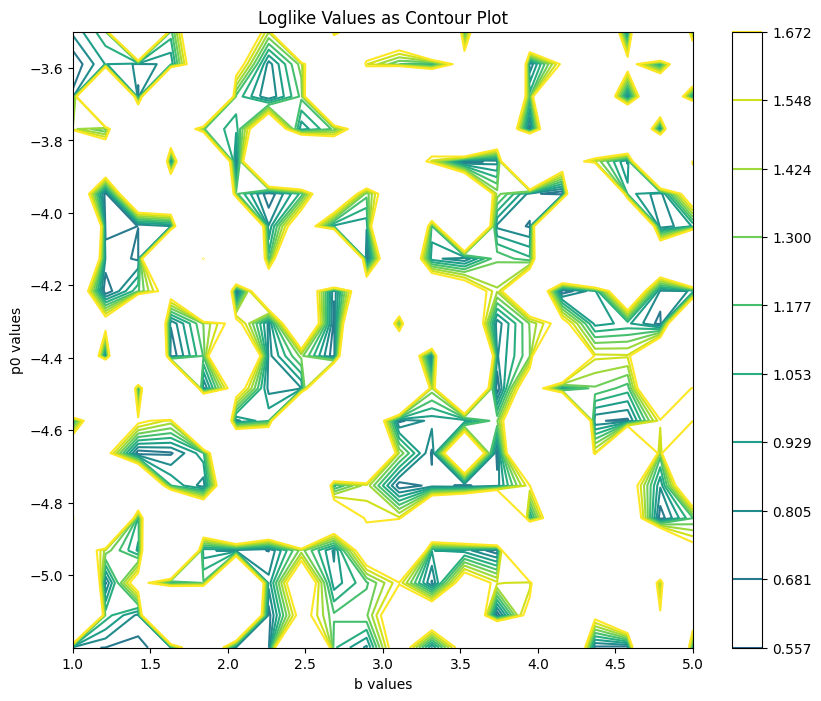

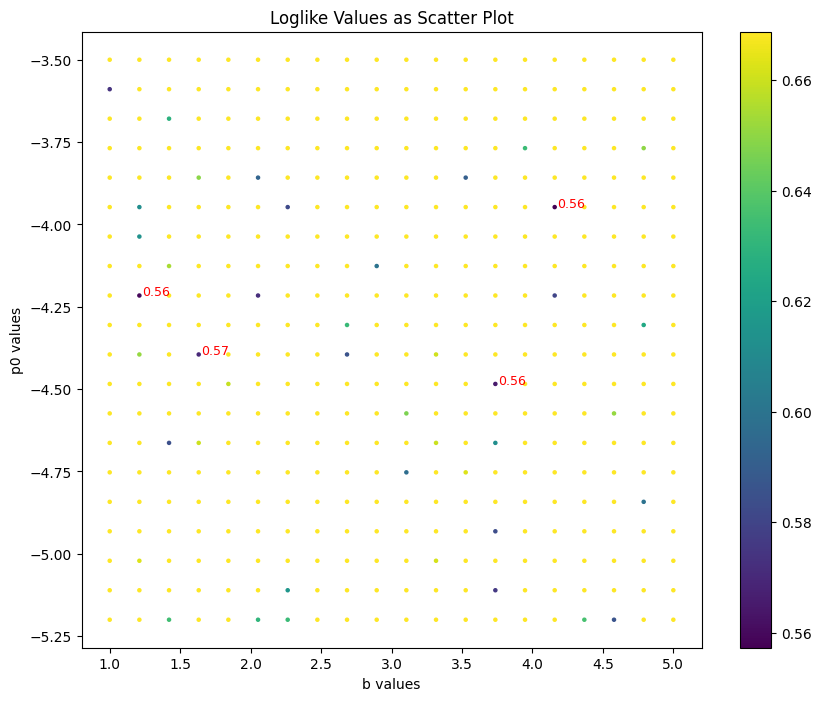

In [165]:
# Fix b and p1

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3_fix_bp1:
    def __init__(self, data_path, constant_b, constant_p1):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p1 = constant_p1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, -13.5, self.constant_p1, -0.95, -0.1], high=[1.9 * 10**5, self.constant_b, -11, self.constant_p1, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 50

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 4:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 5:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

            theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 4:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 5:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                pass
                # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 5
            loss_filter = 10
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 500 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
            #     print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta_opt[i-1])
                if i == 3:
                    theta_final.append(theta[i])
                if i == 4:
                    theta_final.append(theta_opt[i-2])
                if i == 5:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_b_p1():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p1_ft_lower = -5.2 # Real is -15 Viewing is -20
    p1_ft_upper = -3.5 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p1_ft_values = torch.linspace(p1_ft_lower, p1_ft_upper, 20)
    B, P1 = torch.meshgrid(b_ft_values, p1_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p0_ft_values = torch.zeros(B.shape)
    p2_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp1(data_path, b_ft_values[i], p1_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], theta_final[1], theta_final[2], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p0_ft_values[i, j] = theta_final[2]
            p2_ft_values[i, j] = theta_final[4]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p1'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(b_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[i, j].item())
                p1_values_array.append(p1_ft_values[j].item())
                p2_values_array.append(p2_ft_values[i, j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p1')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P1.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[i, j].item())
            p1_values_array.append(p1_ft_values[j].item())
            p2_values_array.append(p2_ft_values[i, j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p1_values_array = np.array(p1_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.57

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
    
for i in range(5):
    contour_plot_b_p1()

## Replot b vs p1

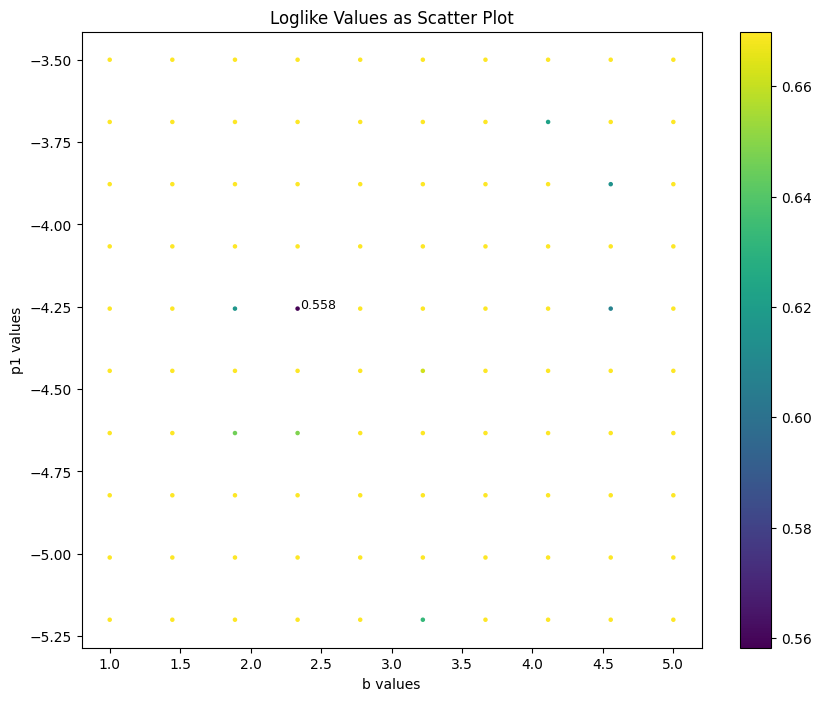

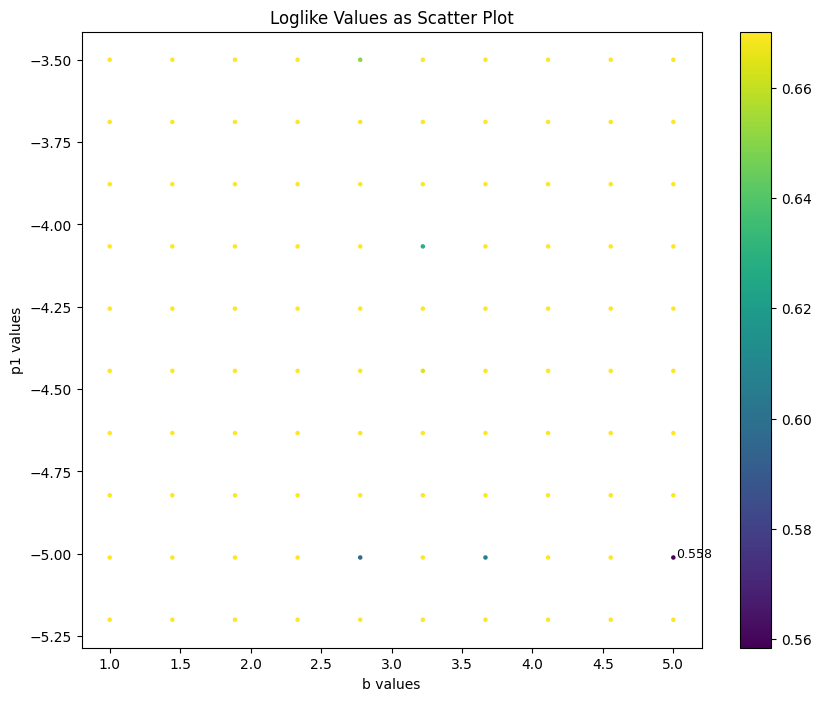

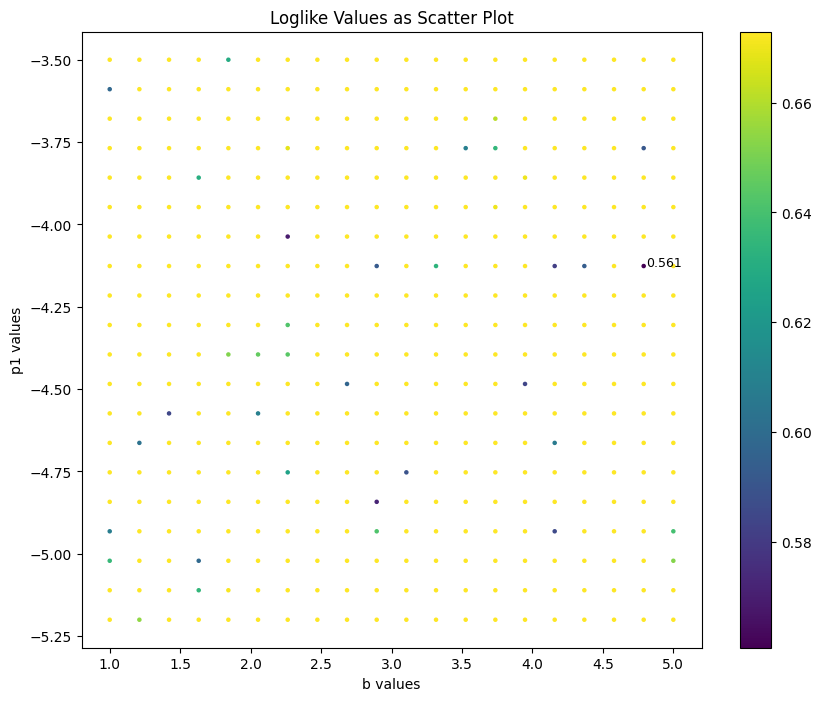

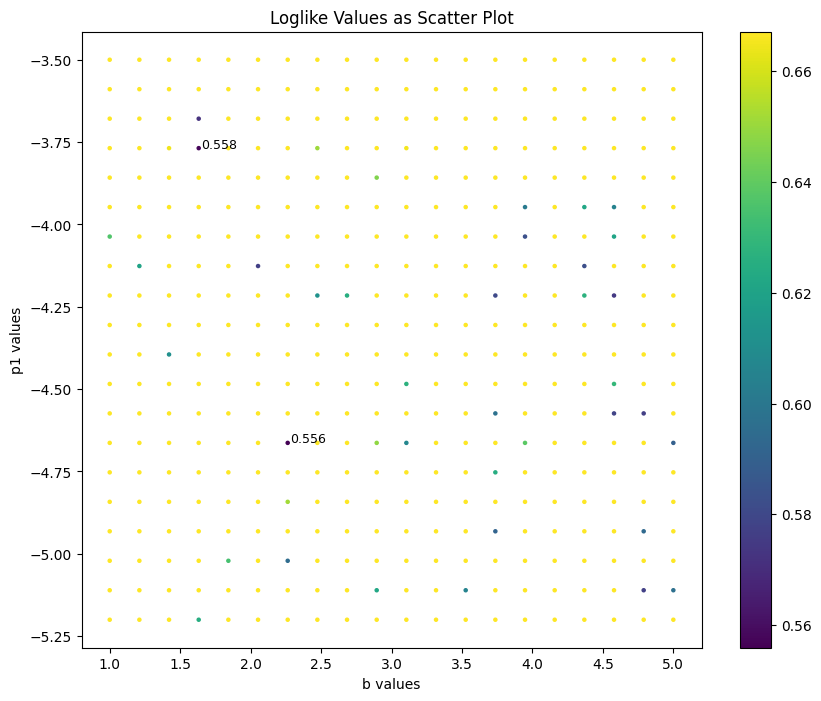

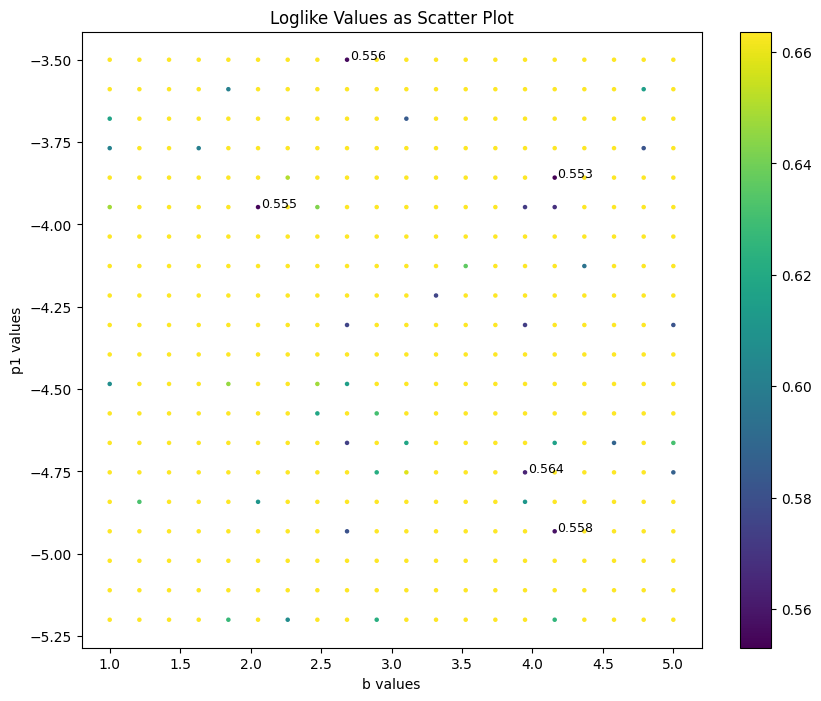

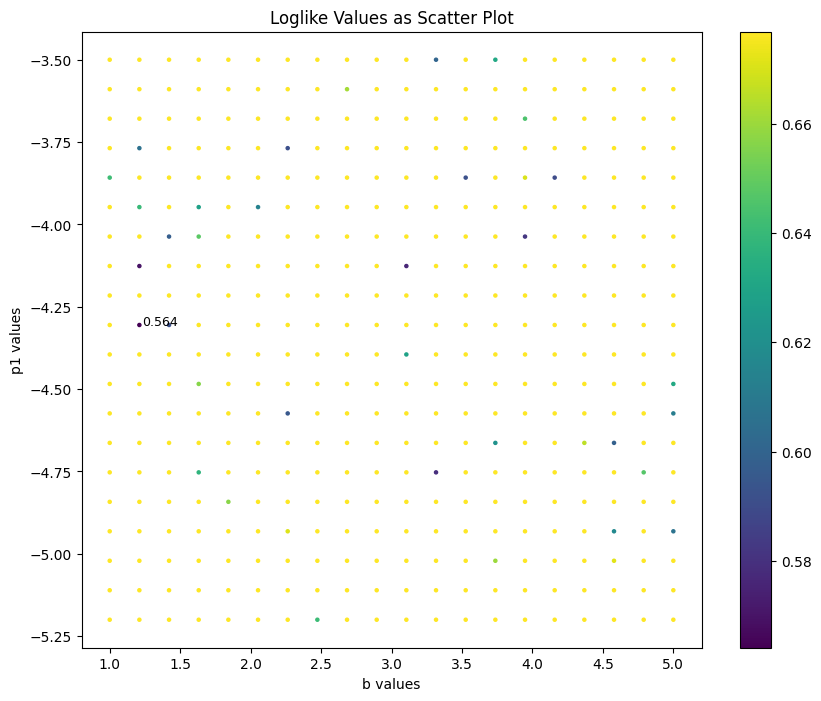

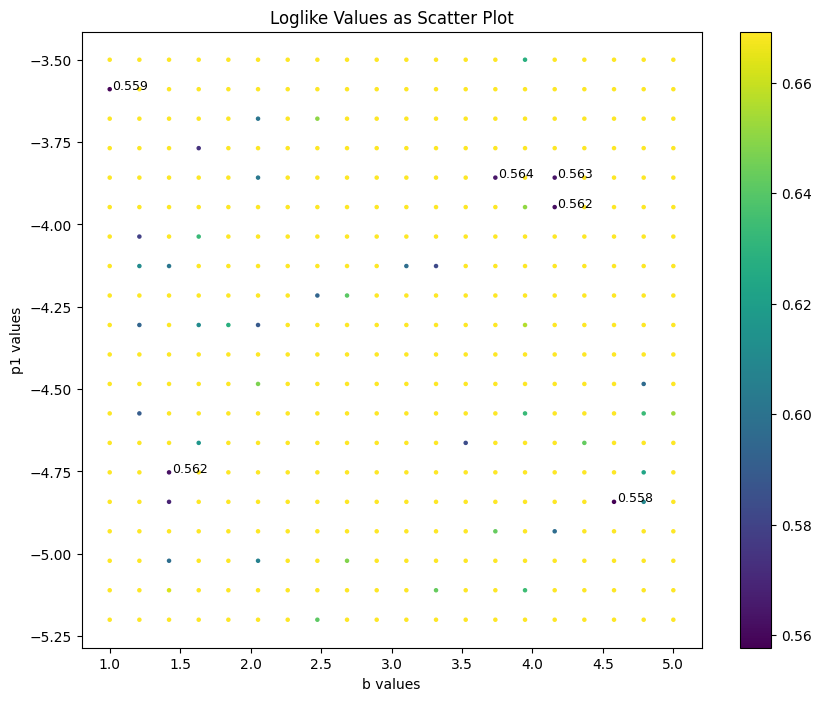

In [243]:
# Plotting results

def replot_scatter_b_p1(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p1 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.565

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i], str(round(loglike_values_array[i], 3)), fontsize=9, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

replot_scatter_b_p1('loglike_history_b_p1_20240312_212506_1.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_212601_2.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_213046_3.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_213406_4.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_213657_5.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_214003_6.csv')
replot_scatter_b_p1('loglike_history_b_p1_20240312_214317_7.csv')

## Plot curves at critical loglike values

In [ ]:
def plot_curve_loglike_crit(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']
    # losses_array = data['losses']

    optimizer_class = optim_p3(data_path)

    x_tensor = optimizer_class.x_tensor
    curve_torch_3 = optimizer_class.curve_torch_3()

    critical_loglike_value = 0.56

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            print(f"""Critical loglike met, loglike = {loglike_val}\n 
                  a = {a_values_array[i]}\n 
                  b = {b_values_array[i]}\n
                  p0 = {p0_values_array[i]}\n
                  p1 = {p1_values_array[i]}\n
                  p2 = {p2_values_array[i]}\n
                  p3 = {p3_values_array[i]}""")
            
            plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            y_pred_3 = curve_torch_3(x_tensor, a_values_array[i], b_values_array[i], p0_values_array[i], p1_values_array[i], p2_values_array[i], p3_values_array[i]).detach().numpy()
            plt.plot(De_mass, y_pred_3)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 4000)
            plt.ylim(top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses_array)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

plot_curve_loglike_crit('loglike_history_20240310_212607_all_params.csv')

## Gradient (misc)

In [1]:
def calc_gradients(b, p0):
    # Placeholder for your model evaluation and log-likelihood calculation
    # You would replace this with calls to your model and log-likelihood functions
    # Ensure `b` and `p0` are PyTorch tensors with `requires_grad=True`
    optimizer_class = optim_p3_fix_abp0(data_path, b, p0)
    optimizer_class.run()
    theta_final = optimizer_class.theta_final
    y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], b, p0, theta_final[3], theta_final[4], theta_final[5])
    loglike_values[i, j] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
    log_likelihood = 
    
    # Calculate gradients
    log_likelihood.backward()
    
    # Access the gradients
    b_grad = b.grad.item()
    p0_grad = p0.grad.item()
    
    return b_grad, p0_grad

SyntaxError: invalid syntax (294395746.py, line 10)

# Narrowing priors (best each point method)

Testing some code which will find the best loglike for each point, so will reduce stochastic effects of starting point etc. Does this by doing following process: choose starting point and optimise, if doesn't reach good loglikelihood within counter_lim then ups the critical loglieklihood and repeats, does this until critical loglikelihood is 0.6, if by then still hasn't reached this loglike then just end loop and plot. This means that can be more sure of loglike of each point since each point has been given a large nnumber of repeats to reach a critical logliekihood.

Modification: Maybe try same start point a few times before changing start point? Would it make much difference or will it optimise in same way? Surely will optimise same way becasue will take the same steps and apth since always steps in steepest gradient direction.

Need to check: Threshold requird to b high for some poionts but doesn't need to for others? Does it affect the other poiint which it doesn't need to be low for? Can I loop over threshold or maybe that would take too long?

## b vs p0

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[0, 5]
Calculated loglike_values[0, 6]
Calculated loglike_values[0, 7]
Calculated loglike_values[0, 8]
Calculated loglike_values[0, 9]
Calculated loglike_values[0, 10]
Calculated loglike_values[0, 11]
Calculated loglike_values[0, 12]
Calculated loglike_values[0, 13]
Calculated loglike_values[0, 14]
Calculated loglike_values[0, 15]
Calculated loglike_values[0, 16]
Calculated loglike_values[0, 17]
Calculated loglike_values[0, 18]
Calculated loglike_values[0, 19]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[1, 5]
Calculated loglike_values[1, 6]
Calculated loglike_values[1, 7]
Calculated loglike_values[1, 8]
Calculated loglike_values[1, 9]
Calculated loglike_values[1, 1

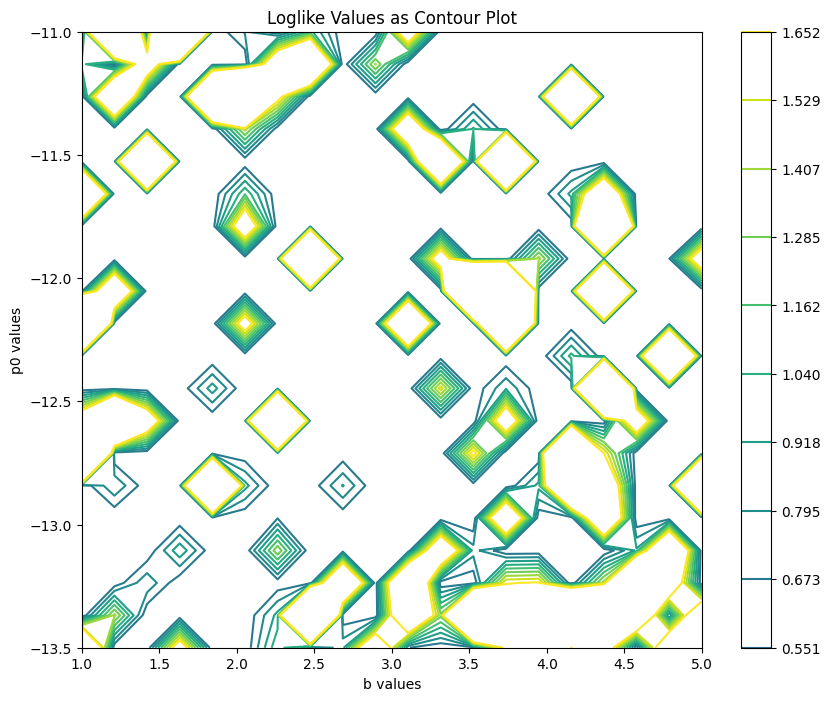

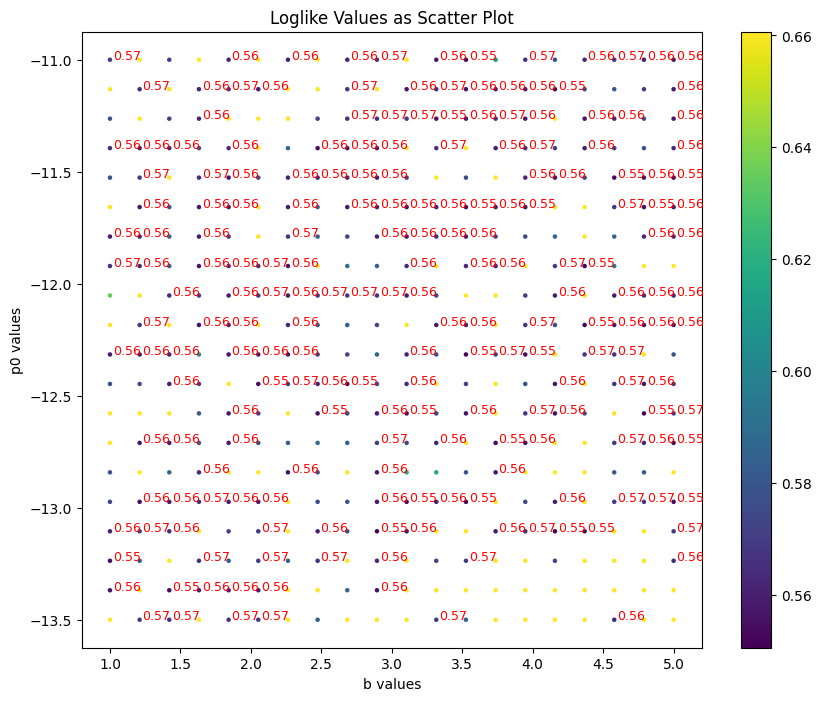

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[0, 5]
Calculated loglike_values[0, 6]
Calculated loglike_values[0, 7]
Calculated loglike_values[0, 8]
Calculated loglike_values[0, 9]
Calculated loglike_values[0, 10]
Calculated loglike_values[0, 11]
Calculated loglike_values[0, 12]
Calculated loglike_values[0, 13]
Calculated loglike_values[0, 14]
Calculated loglike_values[0, 15]
Calculated loglike_values[0, 16]
Calculated loglike_values[0, 17]
Calculated loglike_values[0, 18]
Calculated loglike_values[0, 19]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[1, 5]
Calculated loglike_values[1, 6]
Calculated loglike_values[1, 7]
Calculated loglike_values[1, 8]
Calculated loglike_values[1, 9]
Calculated loglike_values[1, 1

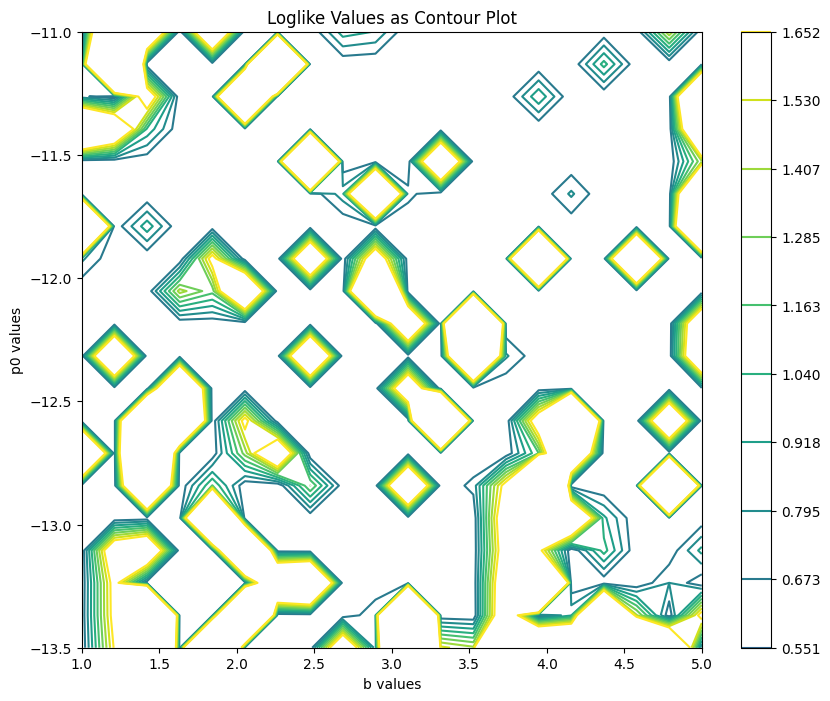

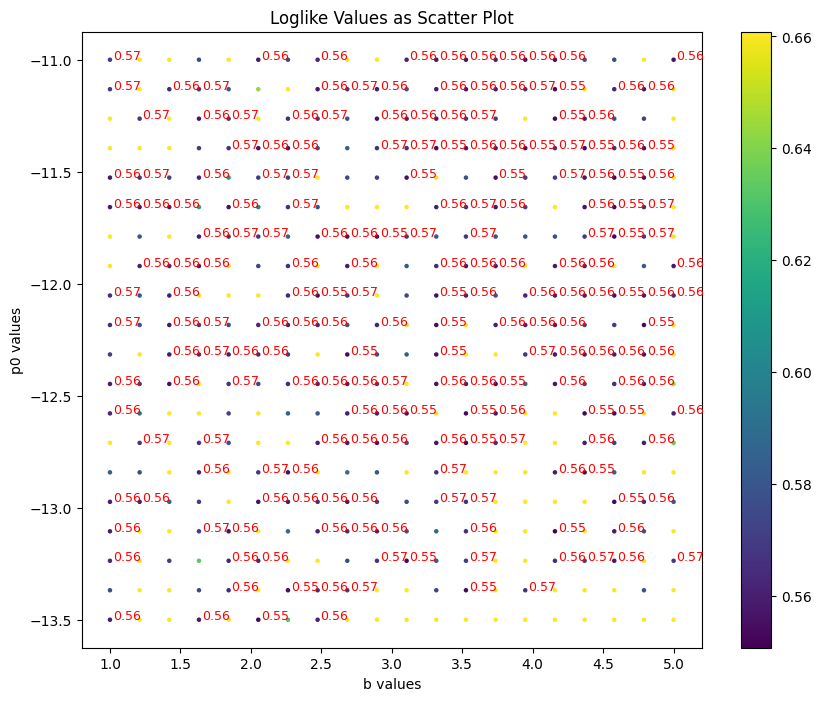

Calculated loglike_values[0, 0]
Calculated loglike_values[0, 1]
Calculated loglike_values[0, 2]
Calculated loglike_values[0, 3]
Calculated loglike_values[0, 4]
Calculated loglike_values[0, 5]
Calculated loglike_values[0, 6]
Calculated loglike_values[0, 7]
Calculated loglike_values[0, 8]
Calculated loglike_values[0, 9]
Calculated loglike_values[0, 10]
Calculated loglike_values[0, 11]
Calculated loglike_values[0, 12]
Calculated loglike_values[0, 13]
Calculated loglike_values[0, 14]
Calculated loglike_values[0, 15]
Calculated loglike_values[0, 16]
Calculated loglike_values[0, 17]
Calculated loglike_values[0, 18]
Calculated loglike_values[0, 19]
Calculated loglike_values[1, 0]
Calculated loglike_values[1, 1]
Calculated loglike_values[1, 2]
Calculated loglike_values[1, 3]
Calculated loglike_values[1, 4]
Calculated loglike_values[1, 5]
Calculated loglike_values[1, 6]
Calculated loglike_values[1, 7]
Calculated loglike_values[1, 8]
Calculated loglike_values[1, 9]
Calculated loglike_values[1, 1

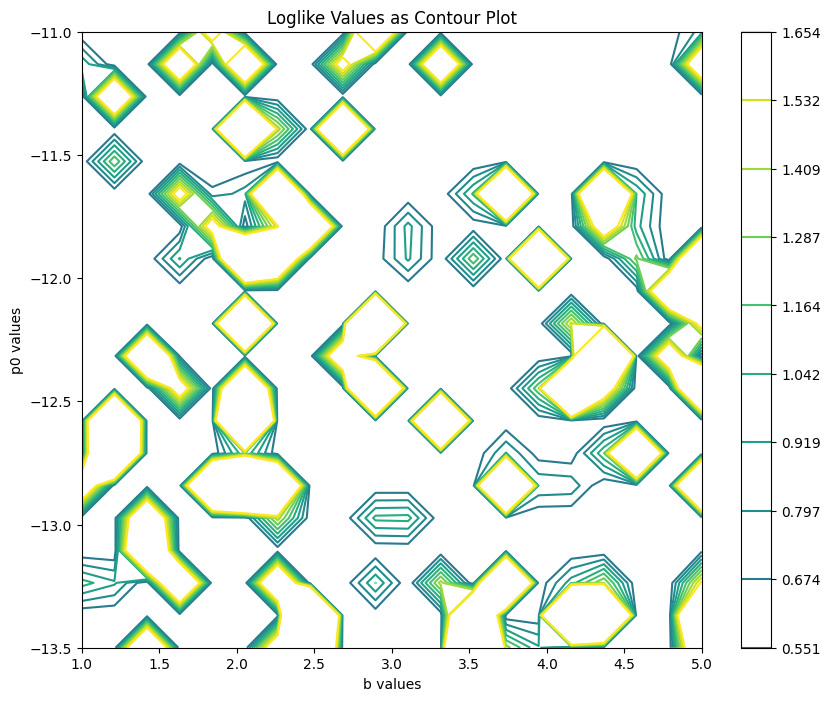

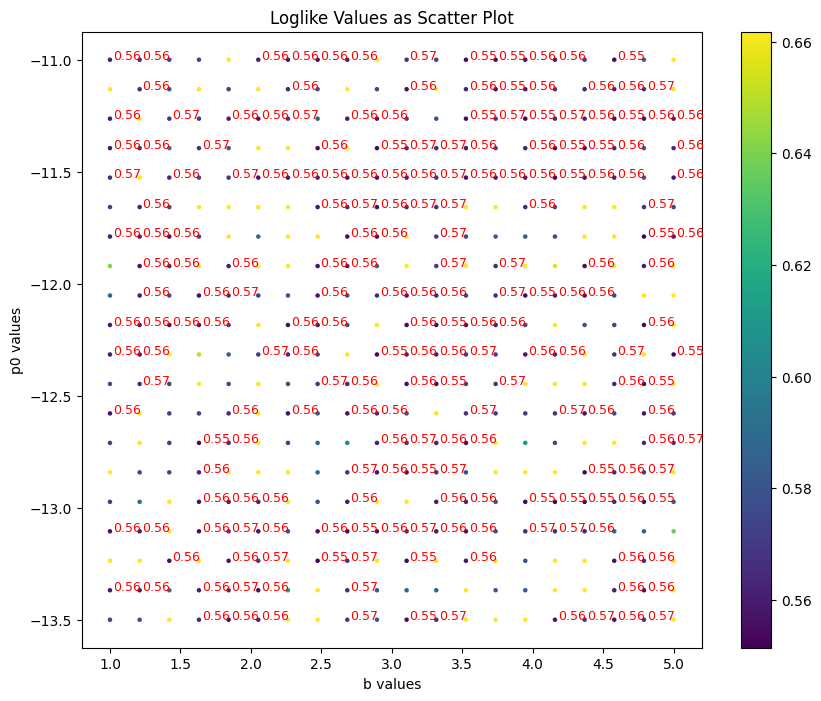

In [ ]:
class optim_p3_fix_bp0_best_each_point:
    def __init__(self, data_path, constant_b, constant_p0):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p0 = constant_p0

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, self.constant_p0, -5.2, -0.95, -0.1], high=[1.9 * 10**5, self.constant_b, self.constant_p0, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self):
        priors = self.create_priors()
        theta = []
        theta_opt = []
        for i in range(len(priors)):
            if i == 0:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 1:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 2:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 3:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 4:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 5:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

        theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

        if self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) >= self.threshold():
            while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
                priors = self.create_priors()
                theta = []
                theta_opt = []
                for i in range(len(priors)):
                    if i == 0:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 1:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 2:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 3:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 4:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 5:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

                theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
    #     print("Starting optimisation")

        success = False

        while not success:

            counter = 0
            counter_lim = 10
            max_N = 1000
            loss_crit = 5
            loss_filter = 0.6
            loss_accept = 0.55
            final_loss_accept = 0.60

            while loss_accept < final_loss_accept:
                while counter <= counter_lim:

                    initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3()
                    optimizer = Adam([theta_opt], lr=0.001)
                    loss = initial_loss
                    losses = []
                    N_iter = 0

                    while N_iter < max_N:
                        # if N_iter == 0:
                        #     print(f"Initial Loss = {loss}")
                        optimizer.zero_grad()
                        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta[2], theta_opt[1], theta_opt[2], theta_opt[3])
                        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                        loss.backward()
                        optimizer.step()
                        losses.append(loss.detach().numpy())
                        N_iter += 1
                        if N_iter == max_N and loss > loss_accept:
                            # print(f"Final Loss too high. Adding 1 to counter.")
                            # print(f"Final Loss = {losses[-1]}, too high. Adding 1 to counter.")
                            counter += 1
                            break
                        if N_iter == max_N and loss <= loss_accept:
                            counter = counter_lim + 1
                            break
                    if loss <= loss_accept:
                        break
                    if counter == counter_lim and loss >= loss_accept:
                        # print("Counter limit reached. Adding 0.01 to loss_accept and resetting counter.")
                        loss_accept += 0.01
                        # print(f"Loss_accept = {loss_accept}, Final_loss_accept = {final_loss_accept}")
                        counter = 0
                        # if loss_accept >= final_loss_accept:
                            # print(f"Loss accept has reached limit.")
                        break
                if loss <= loss_accept:
                    break
                if loss_accept >= final_loss_accept:
                    break
            if loss <= loss_accept:
                success = True
                break
            if loss_accept >= final_loss_accept: #Once total count has been reached, change success to true regardless of loglike value obtained
                success = True
                break

        # if loss < loss_accept: # If escaped total count and counter loops and loss < loss accept then success achieved
        #     print(f"Success achieved, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        # if loss >= loss_accept: # If escaped total count and counter loops only after limit then must mean loss >= loss accept so no success achieved
        #     print(f"Limit reached, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        if success == True:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta[i])
                if i == 3:
                    theta_final.append(theta_opt[i-2])
                if i == 4:
                    theta_final.append(theta_opt[i-2])
                if i == 5:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_bp0_best_each_point():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p0_ft_lower = -13.5 # Real is -15 Viewing is -20
    p0_ft_upper = -11 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p0_ft_values = torch.linspace(p0_ft_lower, p0_ft_upper, 20)
    B, P0 = torch.meshgrid(b_ft_values, p0_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p1_ft_values = torch.zeros(B.shape)
    p2_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp0_best_each_point(data_path, b_ft_values[i], p0_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], theta_final[1], theta_final[2], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p1_ft_values[i, j] = theta_final[3]
            p2_ft_values[i, j] = theta_final[4]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p0_best_each_point'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(b_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[j].item())
                p1_values_array.append(p1_ft_values[i, j].item())
                p2_values_array.append(p2_ft_values[i, j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p0_best_each_point')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P0.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[j].item())
            p1_values_array.append(p1_ft_values[i, j].item())
            p2_values_array.append(p2_ft_values[i, j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p0_values_array = np.array(p0_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.57

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
    
for i in range(3):
    contour_plot_bp0_best_each_point()

## Replot b vs p0

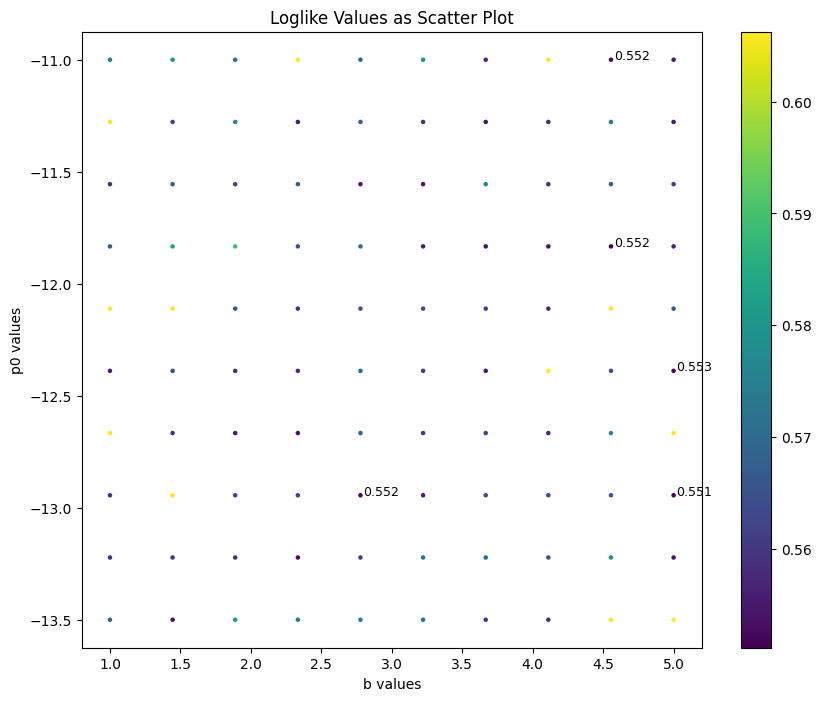

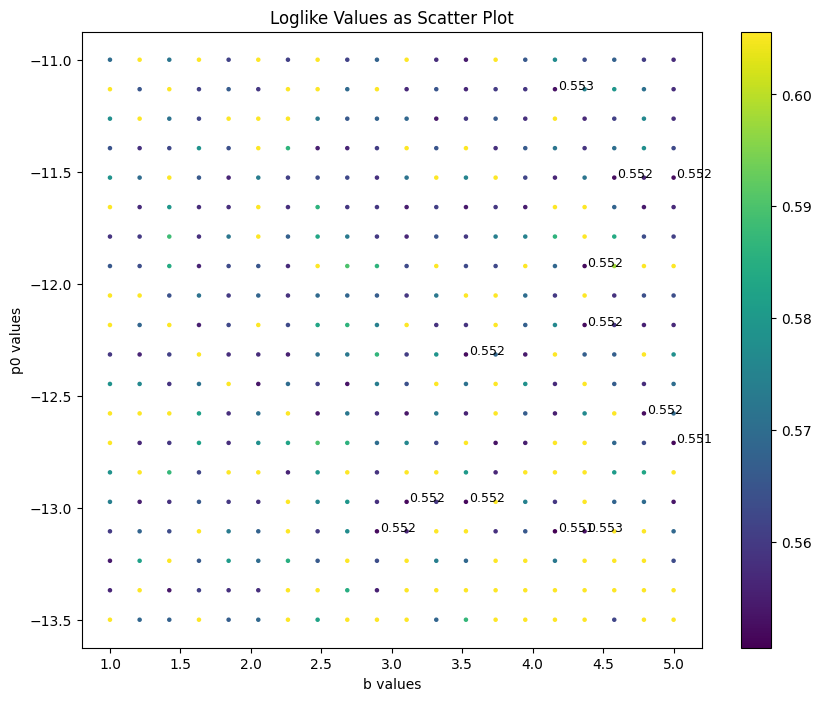

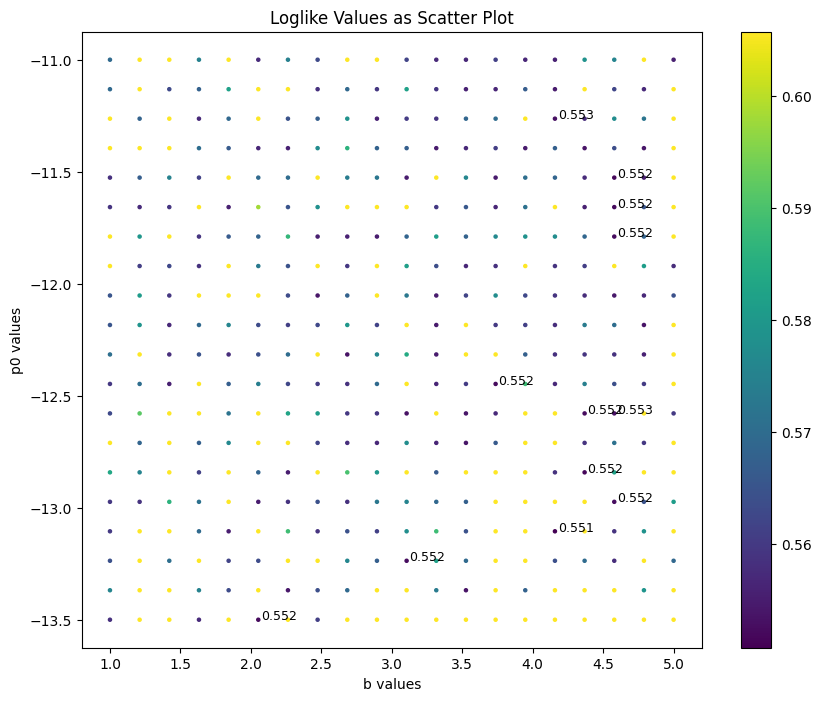

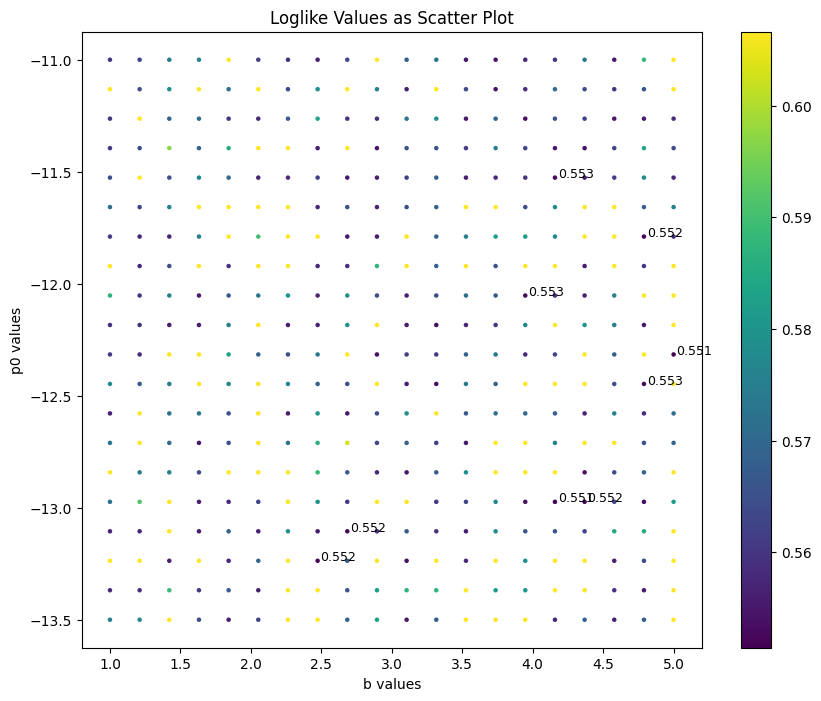

In [ ]:
# Plotting results

def replot_scatter_b_p0(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.1)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.553

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_values_array[i], 3)), fontsize=9, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

replot_scatter_b_p0("loglike_history_b_p0_best_each_point_20240313_235235.csv")
replot_scatter_b_p0("loglike_history_b_p0_best_each_point_20240314_014006.csv")
replot_scatter_b_p0("loglike_history_b_p0_best_each_point_20240314_030139.csv")
replot_scatter_b_p0("loglike_history_b_p0_best_each_point_20240314_042215.csv")

## b vs p1

In [ ]:
class optim_p3_fix_bp1_best_each_point:
    def __init__(self, data_path, constant_b, constant_p1):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p1 = constant_p1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, -13.5, self.constant_p1, -0.95, -0.1], high=[1.9 * 10**5, self.constant_b, -11, self.constant_p1, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 100

    def adjust_theta_3(self):
        priors = self.create_priors()
        theta = []
        theta_opt = []
        for i in range(len(priors)):
            if i == 0:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 1:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 2:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 3:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 4:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 5:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

        theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

        if self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) >= self.threshold():
            while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
                priors = self.create_priors()
                theta = []
                theta_opt = []
                for i in range(len(priors)):
                    if i == 0:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 1:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 2:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 3:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 4:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 5:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

                theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
    #     print("Starting optimisation")

        success = False

        while not success:

            counter = 0
            counter_lim = 20
            max_N = 1000
            loss_crit = 5
            loss_filter = 0.6
            loss_accept = 0.55
            final_loss_accept = 0.60

            while loss_accept < final_loss_accept:
                while counter <= counter_lim:

                    initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3()
                    optimizer = Adam([theta_opt], lr=0.001)
                    loss = initial_loss
                    losses = []
                    N_iter = 0

                    while N_iter < max_N:
                        # if N_iter == 0:
                        #     print(f"Initial Loss = {loss}")
                        optimizer.zero_grad()
                        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta[3], theta_opt[2], theta_opt[3])
                        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                        loss.backward()
                        optimizer.step()
                        losses.append(loss.detach().numpy())
                        N_iter += 1
                        if N_iter == max_N and loss > loss_accept:
                            # print(f"Final Loss too high. Adding 1 to counter.")
                            # print(f"Final Loss = {losses[-1]}, too high. Adding 1 to counter.")
                            counter += 1
                            break
                        if N_iter == max_N and loss <= loss_accept:
                            counter = counter_lim + 1
                            break
                    if loss <= loss_accept:
                        break
                    if counter == counter_lim and loss >= loss_accept:
                        # print("Counter limit reached. Adding 0.01 to loss_accept and resetting counter.")
                        loss_accept += 0.01
                        # print(f"Loss_accept = {loss_accept}, Final_loss_accept = {final_loss_accept}")
                        counter = 0
                        # if loss_accept >= final_loss_accept:
                            # print(f"Loss accept has reached limit.")
                        break
                if loss <= loss_accept:
                    break
                if loss_accept >= final_loss_accept:
                    break
            if loss <= loss_accept:
                success = True
                break
            if loss_accept >= final_loss_accept: #Once total count has been reached, change success to true regardless of loglike value obtained
                success = True
                break

        # if loss < loss_accept: # If escaped total count and counter loops and loss < loss accept then success achieved
        #     print(f"Success achieved, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        # if loss >= loss_accept: # If escaped total count and counter loops only after limit then must mean loss >= loss accept so no success achieved
        #     print(f"Limit reached, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        if success == True:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta_opt[i-1])
                if i == 3:
                    theta_final.append(theta[i])
                if i == 4:
                    theta_final.append(theta_opt[i-2])
                if i == 5:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_bp1_best_each_point():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p1_ft_lower = -5.2 # Real is -15 Viewing is -20
    p1_ft_upper = -3.5 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p1_ft_values = torch.linspace(p1_ft_lower, p1_ft_upper, 20)
    B, P1 = torch.meshgrid(b_ft_values, p1_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p0_ft_values = torch.zeros(B.shape)
    p2_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp1_best_each_point(data_path, b_ft_values[i], p1_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], theta_final[1], theta_final[2], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p0_ft_values[i, j] = theta_final[2]
            p2_ft_values[i, j] = theta_final[4]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p1_best_each_point'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(b_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[i, j].item())
                p1_values_array.append(p1_ft_values[j].item())
                p2_values_array.append(p2_ft_values[i, j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p1_best_each_point')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P1.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p1 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[i, j].item())
            p1_values_array.append(p1_ft_values[j].item())
            p2_values_array.append(p2_ft_values[i, j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p1_values_array = np.array(p1_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p1 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.57

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
    
for i in range(3):
    contour_plot_bp1_best_each_point()

## Replot b vs p1

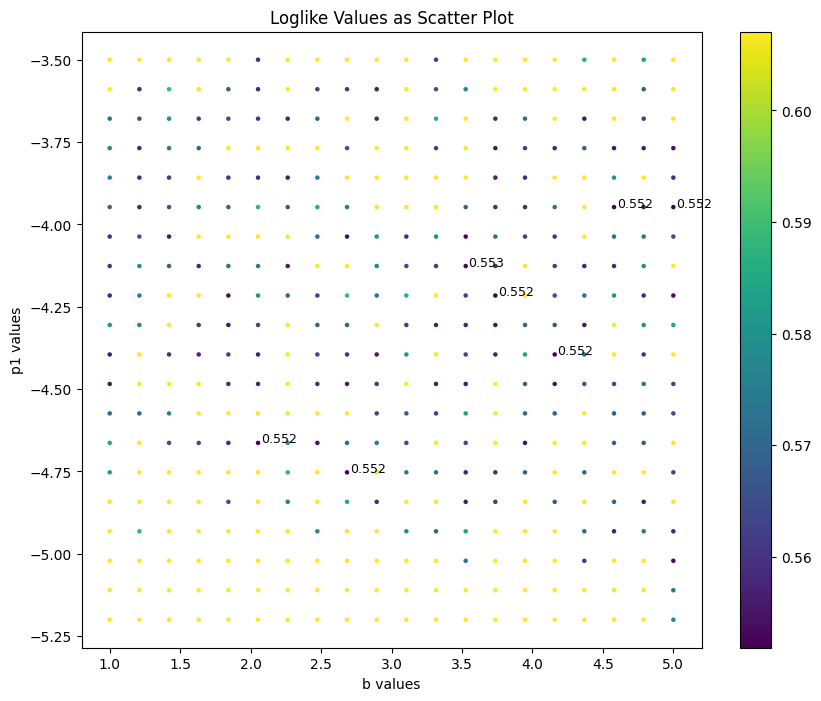

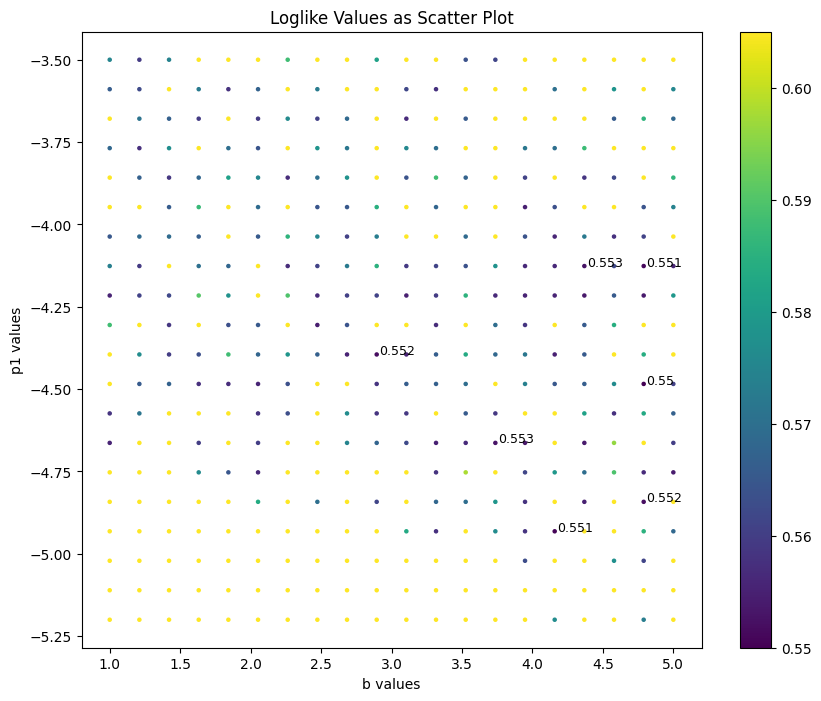

In [ ]:
# Plotting results

def replot_scatter_b_p1(filename):
    
    data = pd.read_csv(filename)

    a_values_array = data['a_values']
    b_values_array = data['b_values']
    p0_values_array = data['p0_values']
    p1_values_array = data['p1_values']
    p2_values_array = data['p2_values']
    p3_values_array = data['p3_values']
    loglike_values_array = data['loglikelihood']

    # Scatter Plotting

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p1_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_array.min(), vmax=loglike_values_array.min()*1.1)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p1 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.553

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p1_values_array[i], str(round(loglike_values_array[i], 3)), fontsize=9, color='black')
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='black')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='grey')
            # print(f"""Critical loglike met, loglike = {loglike_val}\n 
            #       a = {a_values_array[i]}\n 
            #       b = {b_values_array[i]}\n
            #       p0 = {p0_values_array[i]}\n
            #       p1 = {p1_values_array[i]}\n
            #       p2 = {p2_values_array[i]}\n
            #       p3 = {p3_values_array[i]}""")
    plt.show()

replot_scatter_b_p1("loglike_history_b_p1_best_each_point_20240314_072059.csv")
replot_scatter_b_p1("loglike_history_b_p1_best_each_point_20240314_103842.csv")

## b vs p2

In [ ]:
class optim_p3_fix_bp2_best_each_point:
    def __init__(self, data_path, constant_b, constant_p2):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_p2 = constant_p2

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, self.constant_b, -13.5, -5.2, self.constant_p2, -0.1], high=[1.9 * 10**5, self.constant_b, -11, -3.5, self.constant_p2, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 100

    def adjust_theta_3(self):
        priors = self.create_priors()
        theta = []
        theta_opt = []
        for i in range(len(priors)):
            if i == 0:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 1:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 2:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 3:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 4:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            if i == 5:
                theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

        theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
        theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta_opt[2], theta[4], theta_opt[3])
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

        if self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) >= self.threshold():
            while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
                priors = self.create_priors()
                theta = []
                theta_opt = []
                for i in range(len(priors)):
                    if i == 0:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 1:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 2:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 3:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 4:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                    if i == 5:
                        theta.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                        theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))

                theta = torch.tensor(theta, dtype=torch.float32, requires_grad=True)
                theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta_opt[2], theta[4], theta_opt[3])
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        # print("Starting optimisation")

        success = False

        while not success:

            counter = 0
            counter_lim = 20
            max_N = 1000
            loss_crit = 5
            loss_filter = 0.6
            loss_accept = 0.55
            final_loss_accept = 0.60

            while loss_accept < final_loss_accept:
                while counter <= counter_lim:

                    initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3()
                    optimizer = Adam([theta_opt], lr=0.001)
                    loss = initial_loss
                    losses = []
                    N_iter = 0

                    while N_iter < max_N:
                        # if N_iter == 0:
                        #     print(f"Initial Loss = {loss}")
                        optimizer.zero_grad()
                        y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1], theta_opt[2], theta[4], theta_opt[3])
                        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                        loss.backward()
                        optimizer.step()
                        losses.append(loss.detach().numpy())
                        N_iter += 1
                        if N_iter == max_N and loss > loss_accept:
                            # print(f"Final Loss too high. Adding 1 to counter.")
                            # print(f"Final Loss = {losses[-1]}, too high. Adding 1 to counter.")
                            counter += 1
                            break
                        if N_iter == max_N and loss <= loss_accept:
                            counter = counter_lim + 1
                            break
                    if loss <= loss_accept:
                        break
                    if counter == counter_lim and loss >= loss_accept:
                        # print("Counter limit reached. Adding 0.01 to loss_accept and resetting counter.")
                        loss_accept += 0.01
                        # print(f"Loss_accept = {loss_accept}, Final_loss_accept = {final_loss_accept}")
                        counter = 0
                        # if loss_accept >= final_loss_accept:
                            # print(f"Loss accept has reached limit.")
                        break
                if loss <= loss_accept:
                    break
                if loss_accept >= final_loss_accept:
                    break
            if loss <= loss_accept:
                success = True
                break
            if loss_accept >= final_loss_accept: #Once total count has been reached, change success to true regardless of loglike value obtained
                success = True
                break

        # if loss < loss_accept: # If escaped total count and counter loops and loss < loss accept then success achieved
        #     print(f"Success achieved, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        # if loss >= loss_accept: # If escaped total count and counter loops only after limit then must mean loss >= loss accept so no success achieved
        #     print(f"Limit reached, Final loss = {losses[-1]}, Loss accept = {loss_accept}")

        if success == True:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta_opt[i-1])
                if i == 3:
                    theta_final.append(theta_opt[i-1])
                if i == 4:
                    theta_final.append(theta[i])
                if i == 5:
                    theta_final.append(theta_opt[i-2])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            self.losses_array = np.array(losses)

# Pairwise contour plots of loss (loglike() function)

def contour_plot_bp2_best_each_point():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p2_ft_lower = -0.95 # Real is -15 Viewing is -20
    p2_ft_upper = -0.45 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p2_ft_values = torch.linspace(p2_ft_lower, p2_ft_upper, 20)
    B, P2 = torch.meshgrid(b_ft_values, p2_ft_values)
    loglike_values = torch.zeros(B.shape)
    a_ft_values = torch.zeros(B.shape)
    p0_ft_values = torch.zeros(B.shape)
    p1_ft_values = torch.zeros(B.shape)
    p3_ft_values = torch.zeros(B.shape)
    # loglike_b_gradients = torch.zeros(B.shape)
    # loglike_p0_gradients = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_bp2_best_each_point(data_path, b_ft_values[i], p2_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            losses_array = optimizer_class.losses_array
            x_tensor = optimizer_class.x_tensor
            y_tensor = optimizer_class.y_tensor
            y_err_tensor = optimizer_class.y_err_tensor
            y_pred_3 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], theta_final[1], theta_final[2], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3, y_tensor, y_err_tensor)
            a_ft_values[i, j] = theta_final[0]
            p0_ft_values[i, j] = theta_final[2]
            p1_ft_values[i, j] = theta_final[3]
            p3_ft_values[i, j] = theta_final[5]

            # b = b_ft_values[i]
            # p0 = p0_ft_values[j]
            # loglike_values[i,j].backward()
            # loglike_b_gradients[i,j] = b.grad.item()
            # loglike_p0_gradients[i,j] = p0.grad.item()

            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")


    # Save file

    def save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p2_best_each_point'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        a_values_array = []
        b_values_array = []
        p0_values_array = []
        p1_values_array = []
        p2_values_array = []
        p3_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(b_ft_values))):
                a_values_array.append(a_ft_values[i, j].item())
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[i, j].item())
                p1_values_array.append(p1_ft_values[i, j].item())
                p2_values_array.append(p2_ft_values[j].item())
                p3_values_array.append(p3_ft_values[i, j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        a_values_array = np.array(a_values_array)
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        p1_values_array = np.array(p1_values_array)
        p2_values_array = np.array(p2_values_array)
        p3_values_array = np.array(p3_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'a_values': a_values_array,
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'p1_values': p1_values_array,
            'p2_values': p2_values_array,
            'p3_values': p3_values_array,
            'loglikelihood': loglike_values_array,
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, a_ft_values, b_ft_values, p0_ft_values, p1_ft_values, p2_ft_values, p3_ft_values, filename_prefix='loglike_history_b_p2_best_each_point')

    # Contour plotting
    
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P2.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p2 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()
    
    # Scatter Plotting

    a_values_array = []
    b_values_array = []
    p0_values_array = []
    p1_values_array = []
    p2_values_array = []
    p3_values_array = []
    loglike_values_array = []
    # loglike_b_gradients_array = []
    # loglike_p0_gradients_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            a_values_array.append(a_ft_values[i, j].item())
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[i, j].item())
            p1_values_array.append(p1_ft_values[i, j].item())
            p2_values_array.append(p2_ft_values[j].item())
            p3_values_array.append(p3_ft_values[i, j].item())
            loglike_values_array.append(loglike_values[i, j].item())
            # loglike_b_gradients_array.append(loglike_b_gradients[i, j].item())
            # loglike_b_gradients_array.append(loglike_p0_gradients[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p2_values_array = np.array(p2_values_array)
    loglike_values_array = np.array(loglike_values_array)
    # loglike_b_gradients_array = np.array(loglike_b_gradients_array)
    # loglike_p0_gradients_array = np.array(loglike_p0_gradients_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p2_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=loglike_values_np.min(), vmax=loglike_values_np.min()*1.2)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p2 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 0.57

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p2_values_array[i], str(round(loglike_values_array[i], 2)), fontsize=9, color='red')
            # print(f"""Critical loglikelihood met, loglike = {loglike_val}, at: \n  
            #       a = {a_values_array[i]} \n        
            #       b = {b_values_array[i]} \n
            #       p0 = {p0_values_array[i]} \n
            #       p1 = {p1_values_array[i]} \n
            #       p2 = {p2_values_array[i]} \n
            #       p3 = {p3_values_array[i]}""")
        # if critical_loglike_value - critical_loglike_value/10 < loglike_val < critical_loglike_value + critical_loglike_value/10:
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i], str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='orange')
        #     plt.text(b_values_array[i] - 0.02, p0_values_array[i] - 0.02, str(round(loglike_b_gradients_array[i], 2)), fontsize=9, color='green')

    plt.show()

# Call contour plot function
    
for i in range(3):
    contour_plot_bp2_best_each_point()

# Generate data and calculate Bayes factor

In [6]:
def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 1.5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

            if success == True:

                theta_final = []

                for i in range(len(theta_opt)):
                    theta_final.append(theta_opt[i])
            
                self.theta_final = torch.tensor(theta_final, dtype=torch.float32)          

class optim_p4:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04, -0.001])
    
    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 500 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            print(theta_final)

for j in range(2):

    # Usage
    N = 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        # y_pred_3_rvs_priors_noise = 0
        y_pred_3_rvs_priors_noise = torch.poisson(y_pred_3_rvs_priors)
        y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p4(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_4 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_4_rvs_priors = optimizer_class.curve_torch_4(x_tensor, *theta)
        # y_pred_4_rvs_priors_noise = 0  
        y_pred_4_rvs_priors_noise = torch.poisson(y_pred_4_rvs_priors)
        y_pred_4_rvs_priors_plus_noise = y_pred_4_rvs_priors + y_pred_4_rvs_priors_noise
        array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_3)
    D4 = np.array(array_vector_datasets_4)

    X = x_me

    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            # Setting custom batch size and number of epochs
            # kwargs['batch_size'] = 128 # Custom batch size
            kwargs['num_epochs'] = 30  # Custom number of epochs
            super().fit(X, y, **kwargs)
    
    # internal = 16
    # initial = 130

    evidence_network = CustomBinaryClassifierLPop(len(X))

    # evidence_network = BinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D4))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    for k in range(3):

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.8913531303405762
Epoch 2/30, Loss: 0.8465646505355835
Epoch 3/30, Loss: 0.8217542767524719
Epoch 4/30, Loss: 0.82616126537323
Epoch 5/30, Loss: 0.8003646731376648
Epoch 6/30, Loss: 0.795254111289978
Epoch 7/30, Loss: 0.785828173160553
Epoch 8/30, Loss: 0.7771809697151184
Epoch 9/30, Loss: 0.7769883871078491
Epoch 10/30, Loss: 0.7638971209526062
Epoch 11/30, Loss: 0.7606448531150818
Epoch 12/30, Loss: 0.7538039684295654
Epoch 13/30, Loss: 0.7538043856620789
Epoch 14/30, Loss: 0.7480050325393677
Epoch 15/30, Loss: 0.7377254366874695
Epoch 16/30, Loss: 0.7350693345069885
Epoch 17/30, Loss: 0.7491414546966553
Epoch 18/30, Loss: 0.738552987575531
Epoch 19/30, Loss: 0.7307667136192322
Epoch 20/30, Loss: 0.7290594577789307
Epoch 21/30, Loss: 0.7221941947937012
Epoch 22/30, Loss: 0.7266857624053955
Epoch 23/30, Loss: 0.718632161617279
Epoch 24/30, Loss: 0.7203628420829773
Epoch 25/30, Loss: 0.7114965319633484
Epoch 26

# Generate data and calculate Bayes factor (attempt 2 without doubling data)

In [6]:
def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 1.5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

            if success == True:

                theta_final = []

                for i in range(len(theta_opt)):
                    theta_final.append(theta_opt[i])
            
                self.theta_final = torch.tensor(theta_final, dtype=torch.float32)          

class optim_p4:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04, -0.001])
    
    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 500 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            print(theta_final)

for j in range(2):

    # Usage
    N = 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        # y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p4(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_4 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_4_rvs_priors = optimizer_class.curve_torch_4(x_tensor, *theta)
        # y_pred_4_rvs_priors_noise = 0  
        y_pred_4_rvs_priors_plus_noise = torch.poisson(y_pred_4_rvs_priors)
        # y_pred_4_rvs_priors_plus_noise = y_pred_4_rvs_priors + y_pred_4_rvs_priors_noise
        array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_3)
    D4 = np.array(array_vector_datasets_4)

    X = x_me

    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            # Setting custom batch size and number of epochs
            # kwargs['batch_size'] = 128 # Custom batch size
            kwargs['num_epochs'] = 30  # Custom number of epochs
            super().fit(X, y, **kwargs)
    
    # internal = 16
    # initial = 130

    evidence_network = CustomBinaryClassifierLPop(len(X))

    # evidence_network = BinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D4))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    for k in range(3):

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

KeyboardInterrupt: 

# Alternative method by sampling from evidence

# Archive

In [16]:
# def curve_unnorm(x_f, b_f, p0_f, p1_f, p2_f, p3_f):
#   BW2 = gamma / ((x_f*13000 - mz) ** 2 + gamma**2 / 4)
#   curve_f = BW2 * ((1-x_f**1)**b_f) * x_f ** (p0_f*(np.log(x_f)**0) + p1_f*(np.log(x_f)**1) + p2_f*(np.log(x_f)**2) + p3_f*(np.log(x_f)**3))
#   return curve_f

# def norm_func(x_f, a_f):
#   norm_f = a_f/curve_unnorm(x_f, popt[1], popt[2], popt[3], popt[4], popt[5]).sum(axis=-1)
#   return norm_f

# def curve_norm(x_f, a_f):
#   curve1_f = norm_func(x_f, a_f)*curve_unnorm(x_f, popt[1], popt[2], popt[3], popt[4], popt[5])
#   return curve1_f

# popt_norm, pcov_norm = curve_fit(curve_norm, x_me, De_event, popt[0], maxfev = 100000)
# popt, pcov_norm = curve_fit(curve_unnorm, x_me, De_event, popt[0], maxfev = 100000)
# popt, pcov_norm = curve_fit(curve_norm, x_me, De_event, popt[0], maxfev = 100000)

In [17]:
def funcOrig(x):
    c_e = 1
    a = 178000
    b = 1.5
    p0 = -12.38
    p1 = -4.295
    p2 = -0.9191
    p3 = -0.0845
    gamma = 2.4952
    mz = 91.1876
    BW2 = gamma / ((x_me*13000 - mz) ** 2 + gamma**2 / 4)
    
    curve = BW2 * ((1-x_me**(c_e))**b) * x_me ** (p0*(np.log(x_me))**0 + p1*(np.log(x_me)**1) + p2*(np.log(x_me)**2) + p3*(np.log(x_me))**3)
    norm = a/curve.sum(axis=-1)
    curve1 = norm*curve

    return curve1

sum_chi_1 = []
sum_chi_2 = []


for i, elem in enumerate(x_me):
    if De_event[i] > 0:
        sum_chi_1.append(((funcOrig(elem) - De_event[i])**2)/De_event[i])
        sum_chi_2.append(((funcP2(elem, *popt) - De_event[i])**2)/De_event[i])

sum_chi_1 = np.array(sum_chi_1)
sum_chi_2 = np.array(sum_chi_2)


print(f"Original = {np.sum(sum_chi_1)}, Optimised = {np.sum(sum_chi_2)}")
print(f"{np.sum(sum_chi_1) - np.sum(sum_chi_2)}")

Original = 130032318073.58624, Optimised = 1955478148052.7844
-1825445829979.1982


In [18]:
# Introduce if loop to only start optimisation once suitabl starting point found

# if loglike(y_pred_3, y_tensor, y_err_tensor) > 1000:
#     print(f"First loss = {loglike(y_pred_3, y_tensor, y_err_tensor)}. Finding valid starting point.")
#     loss_3_init = loglike(y_pred_3, y_tensor, y_err_tensor)
#     while loss_3_init > 1000:
#         prior_0 = np.random.uniform(100000, 500000, 1)
#         prior_1 = np.random.uniform(1, 10, 1)
#         prior_2 = np.random.uniform(-10, -100, 1)
#         prior_3 = np.random.uniform(-10, -1, 1)
#         prior_4 = np.random.uniform(-1, -0.1, 1)
#         prior_5 = np.random.uniform(-0.01, -0.1, 1)

#         theta_0 = torch.tensor(prior_0, dtype=torch.float32, requires_grad=True)
#         theta_1 = torch.tensor(prior_1, dtype=torch.float32, requires_grad=True)
#         theta_2 = torch.tensor(prior_2, dtype=torch.float32, requires_grad=True)
#         theta_3 = torch.tensor(prior_3, dtype=torch.float32, requires_grad=True)
#         theta_4 = torch.tensor(prior_4, dtype=torch.float32, requires_grad=True)
#         theta_5 = torch.tensor(prior_5, dtype=torch.float32, requires_grad=True)

#         theta = torch.tensor([theta_0, theta_1, theta_2, theta_3, theta_4, theta_5], dtype=torch.float32, requires_grad=True)

#         y_pred_3 = curve_torch_3(x_tensor, theta[0], theta[1], theta[2], theta[3], theta[4], theta[5])

#         loss_3_init = loglike(y_pred_3, y_tensor, y_err_tensor)

# else:
#     loss_3_init = loglike(y_pred_3, y_tensor, y_err_tensor)
#     print("Valid start point")

In [ ]:
# Finding extrema
loglike_values_np = loglike_values.detach().numpy()

# # Smoothing your grid slightly can help with numerical stability
# smoothed_values = gaussian_filter(loglike_values_np, sigma=1)

# Compute gradients
grad_x, grad_y = np.gradient(loglike_values_np, edge_order=2)

extrema_threshold = 0.0003

# Identify points where gradient close to zero
zero_grad_points = np.where(np.logical_and(np.abs(grad_x) < extrema_threshold, np.abs(grad_y) < extrema_threshold))

# zero_grad_points now contains indices of your extrema candidates

print(f"Optimised b = {b_ft_values[zero_grad_points[0]]}, Optimised p0 = {p0_ft_values[zero_grad_points[1]]}")

print("Considering why is b not equal to 1.5 here")

chosen_x = np.where(np.logical_and(b_ft_values > 1.4, b_ft_values < 1.6))
chosen_y = np.where(np.logical_and(p0_ft_values < -12.37, p0_ft_values > -12.39))

print(f"Chosen b = {b_ft_values[chosen_x]}, chosen p0 = {p0_ft_values[chosen_y]}")
print(f"x grad = {grad_x[chosen_x, chosen_y]}, y grad = {grad_y[chosen_x, chosen_y]}")

# Testing areas (not in use rn)

## Testing area 1 (countour and interactive contour)

In [ ]:
### Sped up version of class but now for fixd abp0

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

def curve_torch_3(x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
    c_e_ft = 1
    BW2 = gamma / ((x * 13000 - mz) ** 2 + (gamma ** 2) / 4)
    log_x = torch.log(x)
    curve_ft = BW2 * ((1 - x ** c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
    norm_ft = a_ft / curve_ft.sum()
    return norm_ft * curve_ft

def loglike(y_pred, y, y_err_tensor):
    valid_indices = y_err_tensor > 0
    chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
    return torch.mean(chi_sq)

class optim_p3_fix_abp0:
    def __init__(self, data_path, constant_a, constant_b, constant_p0):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_a = constant_a
        self.constant_b = constant_b
        self.constant_p0 = constant_p0

    def create_priors(self):
        return np.random.uniform(low=[self.constant_a, self.constant_b, self.constant_p0, -7, -1, -0.1], high=[self.constant_a, self.constant_b, self.constant_p0, -1, -0.5, -0.03])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, theta, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i <= 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                if i >= 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta[0], theta[1], theta[2], theta_opt[0], theta_opt[1], theta_opt[2])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i <= 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                if i >= 3:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta[0], theta[1], theta[2], theta_opt[0], theta_opt[1], theta_opt[2])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            else:
                pass
                # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 2500
            loss_crit = 5
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta[0], theta[1], theta[2], theta_opt[0], theta_opt[1], theta_opt[2])
                loss = self.loglike(y_pred_3, y_tensor, y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                if loss < loss_crit:
                    success = True
                    break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > 5.3:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            theta_final = []

            for i in range(len(theta)):
                if i <= 2:
                    theta_final.append(theta[i])
            for i in range(len(theta)):
                if i <= 2:
                    theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

        if success:
            print(f"Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
        #     # Save results if good

        #     timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
        #     filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
        #     filename_theta_final = f"Theta_3_final_{timestamp}.txt"

        #     with open(filename_theta_initial, 'w') as f:
        #         f.write(str(self.theta_final.tolist()))
        #     with open(filename_theta_final, 'w') as f:
        #         f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_np = curve_torch_3(self.x_tensor, self.theta_final[0], self.theta_final[1], self.theta_final[2], self.theta_final[3], self.theta_final[4], self.theta_final[5]).detach().numpy()
            # plt.plot(De_mass, y_pred_3_np)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")

# Pairwise contour plots of loss (loglike() function)

def contour_plot():

    prior_0 = 180000

    # Tensor everything

    theta_0 = torch.tensor(prior_0, dtype=torch.float32)

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 
    p0_ft_lower = -15 # Real is -15 Viewing is -20
    p0_ft_upper = -10 # Real is -6 Viewing is 0

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    p0_ft_values = torch.linspace(p0_ft_lower, p0_ft_upper, 20)
    B, P0 = torch.meshgrid(b_ft_values, p0_ft_values)
    loglike_values = torch.zeros(B.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            # Usage
            data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
            optimizer_class = optim_p3_fix_abp0(data_path, theta_0, b_ft_values[i], p0_ft_values[j])
            optimizer_class.run()
            theta_final = optimizer_class.theta_final
            y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_0, b_ft_values[i], p0_ft_values[j], theta_final[3], theta_final[4], theta_final[5])
            loglike_values[i, j] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
            # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
            print(f"Calculated loglike_values{[i,j]}")

    # Save file

    def save_loglike_values(loglike_values, b_ft_values, p0_ft_values, filename_prefix='loglike_history'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        b_values_array = []
        p0_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            for j in range((len(b_ft_values))):
                b_values_array.append(b_ft_values[i].item())
                p0_values_array.append(p0_ft_values[j].item())
                loglike_values_array.append(loglike_values[i, j].item())
    
        b_values_array = np.array(b_values_array)
        p0_values_array = np.array(p0_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'b_values': b_values_array,
            'p0_values': p0_values_array,
            'loglikelihood': loglike_values_array
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, b_ft_values, p0_ft_values, filename_prefix='loglike_history')

    # Contour plotting
    plt.figure(figsize=(10, 8))
    loglike_values_np = loglike_values.detach().numpy()
    levels = np.linspace(loglike_values_np.min(), loglike_values_np.min()*3, num=10)
    contour = plt.contour(B.numpy(), P0.numpy(), loglike_values_np, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    # print(b_ft_values)
    # print(p0_ft_values)
    # print(B)
    # print(P0)
    # print(loglike_values_np)
    plt.show()
    
    # Scatter Plotting

    b_values_array = []
    p0_values_array = []
    loglike_values_array = []
    
    for i in range(len(b_ft_values)):
        for j in range((len(b_ft_values))):
            b_values_array.append(b_ft_values[i].item())
            p0_values_array.append(p0_ft_values[j].item())
            loglike_values_array.append(loglike_values[i, j].item())
    
    b_values_array = np.array(b_values_array)
    p0_values_array = np.array(p0_values_array)
    loglike_values_array = np.array(loglike_values_array)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(b_values_array, p0_values_array, c=loglike_values_array, cmap='viridis', s=5, vmin=0, vmax=200)
    plt.colorbar(scatter)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Scatter Plot')

    critical_loglike_value = 100

    # Iterate over all points
    for i, loglike_val in enumerate(loglike_values_array):
        if loglike_val < critical_loglike_value:
            plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_val, 1)), fontsize=9, color='red')
    
    plt.show()

# Call contour plot function

contour_plot()


/opt/homebrew/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Initial Loss = 14.499194145202637
Final loss = 4.97276095256275, Number of iterations = 236
Calculated loglike_values[0, 0]
Initial Loss = 3.0020503997802734
Final loss = 3.002050579637366, Number of iterations = 1
Calculated loglike_values[0, 1]
Initial Loss = 18.03022575378418
Final loss = 4.989245038994372, Number of iterations = 179
Calculated loglike_values[0, 2]
Initial Loss = 22.889698028564453
Final loss = 4.562416827243167, Number of iterations = 2
Calculated loglike_values[0, 3]
Initial Loss = 23.95747184753418
Final loss = 4.996158234424199, Number of iterations = 187
Calculated loglike_values[0, 4]
Initial Loss = 7.649322509765625
Final loss = 4.996157076553314, Number of iterations = 19
Calculated loglike_values[0, 5]
Initial Loss = 10.765313148498535
Final loss = 4.970135328162962, Number of iterations = 39
Calculated loglike_values[0, 6]
Initial Loss = 10.147253036499023
Final loss = 4.982616617772652, Number of iterations = 185
Calculated loglike_values[0, 7]
Initial Lo

KeyboardInterrupt: 

[[1. 1. 3. 3.]
 [1. 1. 3. 3.]
 [1. 1. 3. 3.]
 [1. 1. 3. 3.]]
[[-15. -15. -15. -15.]
 [-10. -10. -10. -10.]
 [-15. -15. -15. -15.]
 [-10. -10. -10. -10.]]
[15629.19335938   451.95657349  3324.58300781   742.27453613]


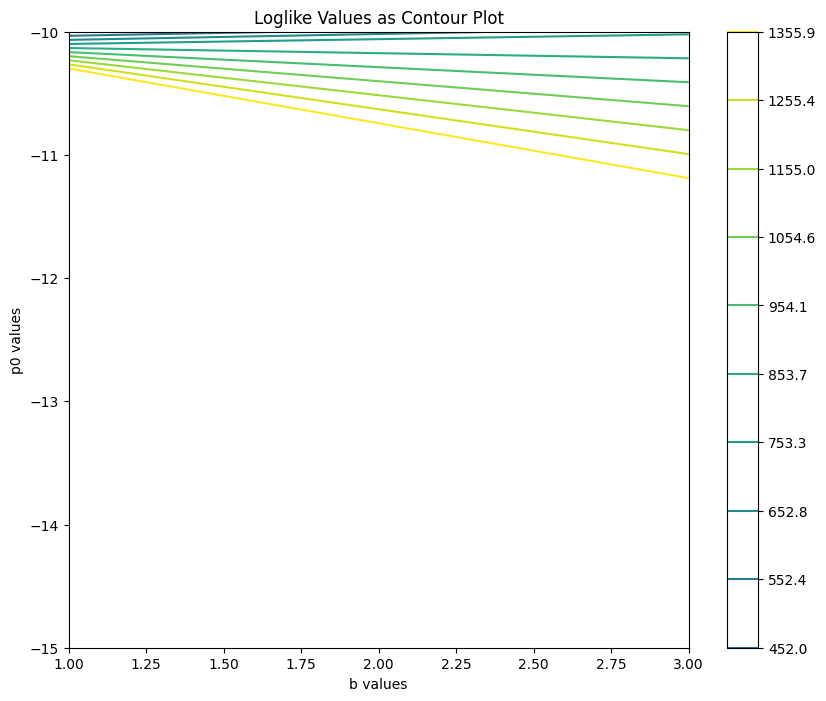

In [ ]:
def replot_contour(filename):
    
    data = pd.read_csv(filename)

    b_values = data['b_values'].values
    p0_values = data['p0_values'].values
    loglike_values = data['loglikelihood'].values

    def unique_ordered(arr):
        # Initialize an empty list to keep track of unique items
        unique_list = []
        # Iterate over each item in the array
        for item in arr:
            # If the item is not already in the list, append it
            if item not in unique_list:
                unique_list.append(item)
        # Convert the list back to a numpy array and return
        return np.array(unique_list)
        

    # Since the original data might not be in a grid form suitable for contour plots,
    # we need to create a grid. Assuming b_values and p0_values are sorted and unique:
    b_values_shape = unique_ordered(b_values)
    b_values = b_values.reshape(len(b_values_shape), len(b_values_shape))
    p0_values = p0_values.reshape(len(b_values_shape), len(b_values_shape))

    B, P0 = np.meshgrid(b_values, p0_values)

    print(B)
    print(P0)
    print(loglike_values)
    
    # Reshape loglikelihood to match the shape of B and P0 for contour plotting
    loglike_grid = loglike_values.reshape(len(b_values_shape), len(b_values_shape))

    # Contour plotting
    plt.figure(figsize=(10, 8))
    levels = np.linspace(loglike_grid.min(), loglike_grid.min()*3, num=10)
    contour = plt.contour(b_values, p0_values, loglike_grid, levels=levels, cmap='viridis', vmin=0, vmax=levels[-1])
    plt.colorbar(contour)
    plt.xlabel('b values')
    plt.ylabel('p0 values')
    plt.title('Loglike Values as Contour Plot')
    plt.show()

replot_contour('loglike_history_20240229_004748.csv')

In [ ]:
def int_contour(filename):# Load the data

    data = pd.read_csv(filename)

    b_values = data['b_values'].values
    p0_values = data['p0_values'].values
    loglike_values = data['loglikelihood'].values

    def unique_ordered(arr):
        # Initialize an empty list to keep track of unique items
        unique_list = []
        # Iterate over each item in the array
        for item in arr:
            for i in range(len(arr)):
                if arr[i] == item:
                    # If the item is not already in the list, append it
                    if item not in unique_list:
                        unique_list.append(item)
        # Convert the list back to a numpy array and return
        return np.array(unique_list)
        

    # Since the original data might not be in a grid form suitable for contour plots,
    # we need to create a grid. Assuming b_values and p0_values are sorted and unique:
    b_values_shape = unique_ordered(b_values)
    # b_values = b_values.reshape(len(b_values_shape), len(b_values_shape))
    # p0_values = p0_values.reshape(len(b_values_shape), len(b_values_shape))
    b_values = unique_ordered(b_values)
    p0_values = unique_ordered(p0_values)

    B, P0 = np.meshgrid(b_values, p0_values)
    
    # Reshape loglikelihood to match the shape of B and P0 for contour plotting
    loglike_grid = loglike_values.reshape(len(b_values_shape), len(b_values_shape))

    fig = go.Figure(data=[go.Surface(z=-loglike_grid, x=B, y=P0)])

    # Customizing the layout
    fig.update_layout(
        title='Interactive 3D Plot of Log-Likelihood',
        autosize=False,
        width=800, 
        height=800,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            xaxis_title='b values',
            yaxis_title='p0 values',
            zaxis_title='- Log-Likelihood',))
            # zaxis=dict(range=[-4, 0])))

    fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

    # Update scenes for better 3D interaction controls

    fig.update_scenes(
        aspectratio=dict(x=1, y=1, z=0.7),
        camera_eye=dict(x=1.25, y=1.25, z=1.25)
    )

    fig.show()

    print(b_values)
    print(p0_values)
    print(loglike_grid)

int_contour('loglike_history_20240229_060044_IMP_b1to5_p0-15to-10.csv')

[1. 3.]
[-15. -10.]
[[15629.19335938   451.95657349]
 [ 3324.58300781   742.27453613]]


In [ ]:
def int_contour(filename):# Load the data

    data = pd.read_csv(filename)

    b_values = data['b_values'].values
    p0_values = data['p0_values'].values
    loglike_values = data['loglikelihood'].values

    def unique_ordered(arr):
        # Initialize an empty list to keep track of unique items
        unique_list = []
        # Iterate over each item in the array
        for item in arr:
            # If the item is not already in the list, append it
            if item not in unique_list:
                unique_list.append(item)
        # Convert the list back to a numpy array and return
        return np.array(unique_list)
        

    # Since the original data might not be in a grid form suitable for contour plots,
    # we need to create a grid. Assuming b_values and p0_values are sorted and unique:
    b_values_shape = unique_ordered(b_values)
    b_values = b_values.reshape(len(b_values_shape), len(b_values_shape))
    p0_values = p0_values.reshape(len(b_values_shape), len(b_values_shape))
    
    # Reshape loglikelihood to match the shape of B and P0 for contour plotting
    loglike_grid = loglike_values.reshape(len(b_values_shape), len(b_values_shape))

    fig = go.Figure(data=[go.Surface(z=-loglike_grid, x=b_values, y=p0_values, cmin=-100, cmax=0)])

    # Customizing the layout
    fig.update_layout(
        title='Interactive 3D Plot of Log-Likelihood',
        autosize=False,
        width=800, 
        height=800,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            xaxis_title='b values',
            yaxis_title='p0 values',
            zaxis_title='- Log-Likelihood',))
            # zaxis=dict(range=[-8, 0])))

    fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

    # Update scenes for better 3D interaction controls

    fig.update_scenes(
        aspectratio=dict(x=1, y=1, z=0.7),
        camera_eye=dict(x=1.25, y=1.25, z=1.25))

    fig.show()

int_contour('loglike_history_20240229_060044_IMP_b1to5_p0-15to-10.csv')

In [ ]:
# Load the data
filename = 'loglike_history_20240227_112528_IMP_2_b3to5.5_p0-14to-11.csv'  # Update this to your actual filename
data = pd.read_csv(filename)

b_values = data['b_values'].values
b_values = b_values[::-1]
p0_values = data['p0_values'].values
p0_values = p0_values[::-1]
loglike_values = data['loglikelihood'].values
loglike_values = loglike_values[::-1]

# Assuming your b_values and p0_values are already grid-like, reshape them
unique_b = np.unique(b_values)
unique_p0 = np.unique(p0_values)
B, P0 = np.meshgrid(unique_b, unique_p0)

# Reshape loglike_values similarly
loglike_values = loglike_values.reshape(B.shape)

# # Create the plot
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D contour
# levels = np.linspace(loglike_values.min(), 200, num=1000)
# surf = ax.contour3D(B, P0, -loglike_values, levels=levels, cmap='viridis', vmin=0, vmax=200, edgecolor='none', rstride=1, cstride=1, linewidth=0, antialiased=False)
# fig.colorbar(surf)

# ax.set_xlabel('b values')
# ax.set_ylabel('p0 values')
# ax.set_zlabel('Log-Likelihood')
# ax.set_title('3D Contour Plot of Log-Likelihood against b and p0')
# ax.set_zlim(bottom=0, top=200)

fig = go.Figure(data=[go.Surface(z=-loglike_values, x=B, y=P0, cmin=-4, cmax=0)])

# Customizing the layout
fig.update_layout(
    title='Interactive 3D Plot of Log-Likelihood',
    autosize=False,
    width=800, 
    height=800,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='b values',
        yaxis_title='p0 values',
        zaxis_title='- Log-Likelihood',
        zaxis=dict(range=[-4, 0])))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

# Update scenes for better 3D interaction controls

fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    camera_eye=dict(x=1.25, y=1.25, z=1.25)
)

fig.show()

In [ ]:
# Load the data
filename = 'loglike_history_20240227_120001_IMP_3_b5.5to8_p0-14to-11.csv'  # Update this to your actual filename
data = pd.read_csv(filename)

b_values = data['b_values'].values
p0_values = data['p0_values'].values
loglike_values = data['loglikelihood'].values

# Assuming your b_values and p0_values are already grid-like, reshape them
unique_b = np.unique(b_values)
unique_p0 = np.unique(p0_values)
B, P0 = np.meshgrid(unique_b, unique_p0)

# Reshape loglike_values similarly
loglike_values = loglike_values.reshape(B.shape)

# # Create the plot
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D contour
# levels = np.linspace(loglike_values.min(), 200, num=1000)
# surf = ax.contour3D(B, P0, -loglike_values, levels=levels, cmap='viridis', vmin=0, vmax=200, edgecolor='none', rstride=1, cstride=1, linewidth=0, antialiased=False)
# fig.colorbar(surf)

# ax.set_xlabel('b values')
# ax.set_ylabel('p0 values')
# ax.set_zlabel('Log-Likelihood')
# ax.set_title('3D Contour Plot of Log-Likelihood against b and p0')
# ax.set_zlim(bottom=0, top=200)

fig = go.Figure(data=[go.Surface(z=loglike_values, x=B, y=P0, cmin=-4, cmax=0)])

# Customizing the layout
fig.update_layout(
    title='Interactive 3D Plot of Log-Likelihood',
    autosize=False,
    width=800, 
    height=800,
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(
        xaxis_title='b values',
        yaxis_title='p0 values',
        zaxis_title='Log-Likelihood',
        zaxis=dict(range=[9, 0])))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

# Update scenes for better 3D interaction controls

fig.update_scenes(
    aspectratio=dict(x=1, y=1, z=0.7),
    camera_eye=dict(x=1.25, y=1.25, z=1.25)
)

fig.show()

## Testing area 2 (Scanning b against loglikelihood, optimising all others)

Final loss = 1012.0423969775399, Number of iterations = 5000
Calculated loglike_values[0]
Final loss = 1846.179174687742, Number of iterations = 5000
Calculated loglike_values[1]
Final loss = 1231.1938654544858, Number of iterations = 5000
Calculated loglike_values[2]
Final loss = 1278.323215043453, Number of iterations = 5000
Calculated loglike_values[3]
Final loss = 1474.604621629812, Number of iterations = 5000
Calculated loglike_values[4]
Final loss = 1165.169770722607, Number of iterations = 5000
Calculated loglike_values[5]
Final loss = 955.3012160268364, Number of iterations = 5000
Calculated loglike_values[6]
Final loss = 1317.8890843504091, Number of iterations = 5000
Calculated loglike_values[7]
Final loss = 1827.6877121046525, Number of iterations = 5000
Calculated loglike_values[8]
Final loss = 866.0620625747374, Number of iterations = 5000
Calculated loglike_values[9]
Final loss = 1692.8675771929165, Number of iterations = 5000
Calculated loglike_values[10]
Final loss = 83

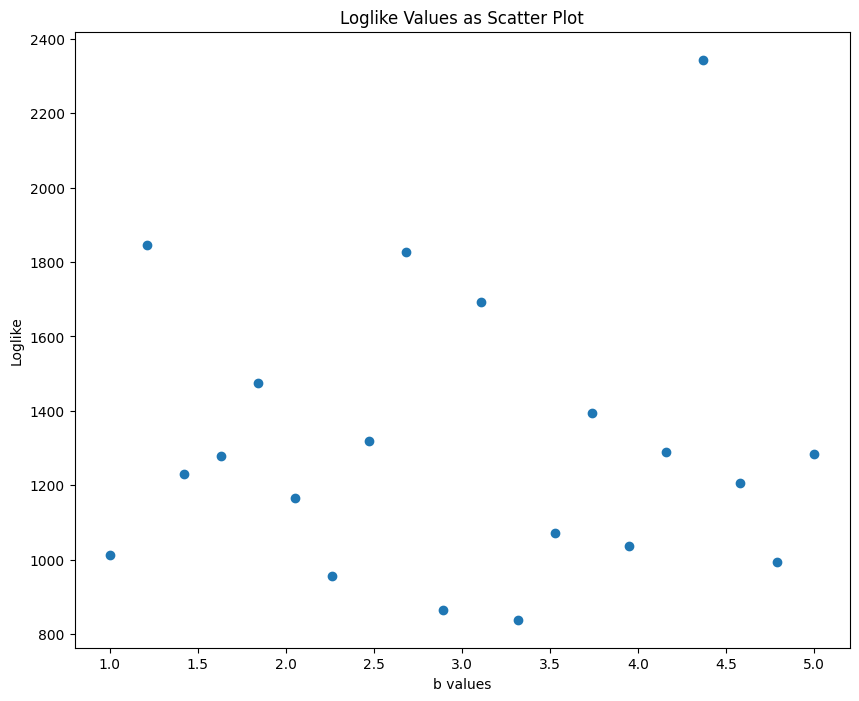

In [ ]:
def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3_only_abp0:
    def __init__(self, data_path, constant_b):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b

    def create_priors(self):
        return np.random.uniform(low=[10**5, self.constant_b, -15], high=[2 * 10**5, self.constant_b, -10])
    
    def curve_torch_3(self, x, a_ft, b_ft, p0_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 10**5

    def adjust_theta_3(self, theta, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                if i == 2:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 5000
            loss_crit = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1], theta_opt[1])
                loss = self.loglike(y_pred_3, y_tensor, y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                # if N_iter == 1000 and loss > 5.3:
                #     # print("Loss too high. Starting again.")
                #     break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
                if i == 2:
                    theta_final.append(theta_opt[i-1])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            print(f"Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

# Pairwise contour plots of loss (loglike() function)

def b_loglike_scan_only_abp0():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 20)
    loglike_values = torch.zeros(b_ft_values.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_only_abp0(data_path, b_ft_values[i])
        optimizer_class.run()
        theta_final = optimizer_class.theta_final
        y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], b_ft_values[i], theta_final[2])
        loglike_values[i] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
        # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
        print(f"Calculated loglike_values{[i]}")

    # Save file

    def save_loglike_values(loglike_values, b_ft_values, filename_prefix='loglike_history_bvsloglike'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        b_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            b_values_array.append(b_ft_values[i].item())
            loglike_values_array.append(loglike_values[i].item())
    
        b_values_array = np.array(b_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'b_values': b_values_array,
            'loglikelihood': loglike_values_array
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, b_ft_values, filename_prefix='loglike_history_bvsloglike')
    
    # Scatter Plotting

    b_values_array = []
    loglike_values_array = []
    
    for i in range(len(b_ft_values)):
        b_values_array.append(b_ft_values[i].item())
        loglike_values_array.append(loglike_values[i].item())
    
    b_values_array = np.array(b_values_array)
    loglike_values_array = np.array(loglike_values_array)

    plt.figure(figsize=(10, 8))
    plt.scatter(b_values_array, loglike_values_array)
    plt.xlabel('b values')
    plt.ylabel('Loglike')
    plt.title('Loglike Values as Scatter Plot')

    # critical_loglike_value = 100

    # # Iterate over all points
    # for i, loglike_val in enumerate(loglike_values_array):
    #     if loglike_val < critical_loglike_value:
    #         plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_val, 1)), fontsize=9, color='red')
    
    plt.show()

# Call contour plot function

b_loglike_scan_only_abp0()

Final loss = 2157.3536024904483, Number of iterations = 5000
Calculated loglike_values[0], Loglike = 2157.353515625, a = 132129.234375
Final loss = 1949.985483797782, Number of iterations = 5000
Calculated loglike_values[1], Loglike = 1949.9854736328125, a = 130857.75
Final loss = 3642.0852295636923, Number of iterations = 5000
Calculated loglike_values[2], Loglike = 3642.085205078125, a = 197782.140625
Final loss = 2111.744386699823, Number of iterations = 5000
Calculated loglike_values[3], Loglike = 2111.744384765625, a = 155979.921875
Final loss = 2480.5108436073697, Number of iterations = 5000
Calculated loglike_values[4], Loglike = 2480.5107421875, a = 179319.328125
Final loss = 1675.7859829143938, Number of iterations = 5000
Calculated loglike_values[5], Loglike = 1675.7860107421875, a = 150462.515625
Final loss = 1353.4671153444376, Number of iterations = 5000
Calculated loglike_values[6], Loglike = 1353.4671630859375, a = 135561.546875
Final loss = 1913.1855089191797, Number of

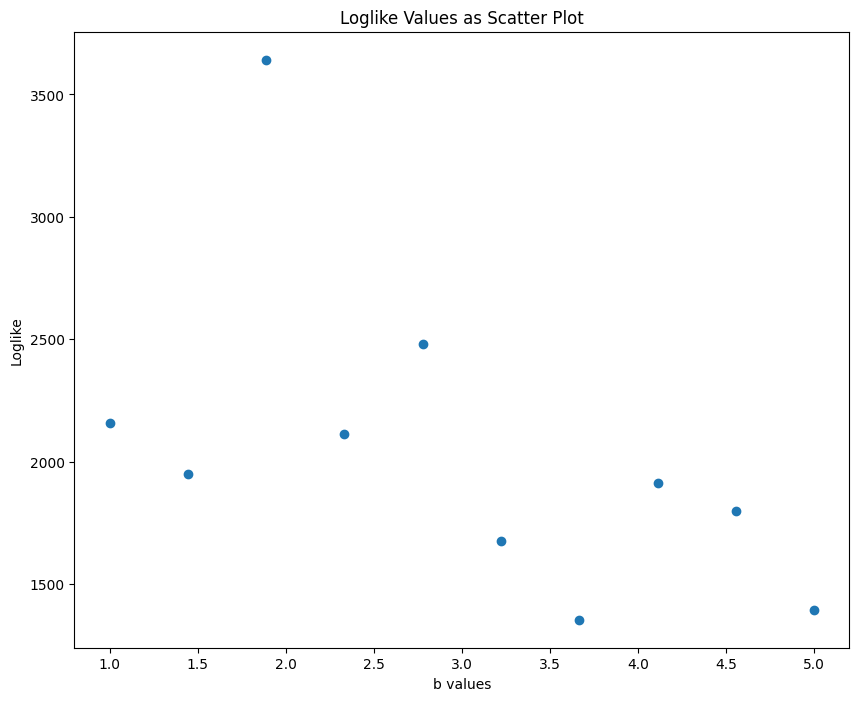

In [11]:
def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3_only_ab:
    def __init__(self, data_path, constant_b):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b

    def create_priors(self):
        return np.random.uniform(low=[10**5, self.constant_b], high=[2 * 10**5, self.constant_b])
    
    def curve_torch_3(self, x, a_ft, b_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 10**5

    def adjust_theta_3(self, theta, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1])
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta = []
            theta_opt = []
            for i in range(len(priors)):
                if i == 0:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
                    theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
                if i == 1:
                    theta.append(torch.tensor(priors[i], dtype=torch.float32))
            theta = torch.tensor(theta, dtype=torch.float32)
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1])
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta, theta_opt, y_pred_3 = self.adjust_theta_3(theta, y_pred_3)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 5000
            loss_crit = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, theta_opt[0], theta[1])
                loss = self.loglike(y_pred_3, y_tensor, y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                # if N_iter == 1000 and loss > 5.3:
                #     # print("Loss too high. Starting again.")
                #     break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta)):
                if i == 0:
                    theta_final.append(theta_opt[i])
                if i == 1:
                    theta_final.append(theta[i])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            print(f"Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

# Pairwise contour plots of loss (loglike() function)

def b_loglike_scan_only_ab():

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 5 # Real is 1 Viewing is 

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 10)
    loglike_values = torch.zeros(b_ft_values.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_only_ab(data_path, b_ft_values[i])
        optimizer_class.run()
        theta_final = optimizer_class.theta_final
        y_pred_3_b_p0 = optimizer_class.curve_torch_3(x_tensor, theta_final[0], b_ft_values[i])
        loglike_values[i] = optimizer_class.loglike(y_pred_3_b_p0, y_tensor, y_err_tensor)
        # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
        print(f"Calculated loglike_values{[i]}, Loglike = {loglike_values[i]}, a = {theta_final[0]}")

    # Save file

    def save_loglike_values(loglike_values, b_ft_values, filename_prefix='loglike_history_bvsloglike'):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"
        
        loglike_values = loglike_values.detach().numpy()

        b_values_array = []
        loglike_values_array = []
    
        for i in range(len(b_ft_values)):
            b_values_array.append(b_ft_values[i].item())
            loglike_values_array.append(loglike_values[i].item())
    
        b_values_array = np.array(b_values_array)
        loglike_values_array = np.array(loglike_values_array)

        # Create a DataFrame with appropriate headers
        df = pd.DataFrame({
            'b_values': b_values_array,
            'loglikelihood': loglike_values_array
        })

        # Save the DataFrame to a new CSV file with headers
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

    save_loglike_values(loglike_values, b_ft_values, filename_prefix='loglike_history_bvsloglike')
    
    # Scatter Plotting

    b_values_array = []
    loglike_values_array = []
    
    for i in range(len(b_ft_values)):
        b_values_array.append(b_ft_values[i].item())
        loglike_values_array.append(loglike_values[i].item())
    
    b_values_array = np.array(b_values_array)
    loglike_values_array = np.array(loglike_values_array)

    plt.figure(figsize=(10, 8))
    plt.scatter(b_values_array, loglike_values_array)
    plt.xlabel('b values')
    plt.ylabel('Loglike')
    plt.title('Loglike Values as Scatter Plot')

    # critical_loglike_value = 100

    # # Iterate over all points
    # for i, loglike_val in enumerate(loglike_values_array):
    #     if loglike_val < critical_loglike_value:
    #         plt.text(b_values_array[i] + 0.02, p0_values_array[i], str(round(loglike_val, 1)), fontsize=9, color='red')
    
    plt.show()

# Call contour plot function

b_loglike_scan_only_ab()

Calculated loglike_values[0]
Calculated loglike_values[1]
Calculated loglike_values[2]
Calculated loglike_values[3]
Calculated loglike_values[4]
Calculated loglike_values[5]
Calculated loglike_values[6]
Calculated loglike_values[7]
Calculated loglike_values[8]
Calculated loglike_values[9]


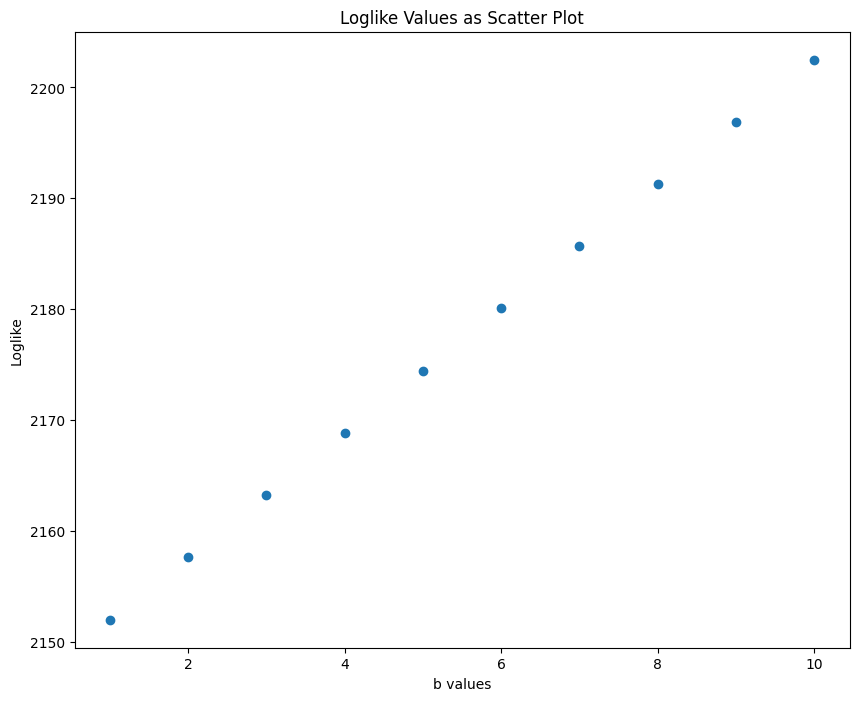

interactive(children=(FloatSlider(value=-10.0, continuous_update=False, description='p0', max=0.0, min=-15.0),…

<function __main__.b_loglike_scan_fix_a_slider_p0(p0)>

In [7]:
def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3_only_b:
    def __init__(self, data_path, constant_a, constant_b, p0):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1
        self.constant_b = constant_b
        self.constant_a = constant_a
        self.p0 = p0

    def create_priors(self):
        return np.random.uniform(low=[self.constant_b], high=[self.constant_b])
    
    def curve_torch_3(self, x, a_ft, b_ft, p0):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** p0
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

# Pairwise contour plots of loss (loglike() function)

def b_loglike_scan_fix_a_slider_p0(p0):

    # Grid of parameters
    b_ft_lower = 1 # Real is 10 Viewing is 
    b_ft_upper = 10 # Real is 1 Viewing is 

    b_ft_values = torch.linspace(b_ft_lower, b_ft_upper, 10)
    loglike_values = torch.zeros(b_ft_values.shape)

    # Evaluate loglike over the grid for optimised values of other parameters
    for i in range(len(b_ft_values)):
        # Usage
        data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
        optimizer_class = optim_p3_only_b(data_path, 180000, b_ft_values[i], p0)
        # optimizer_class.run()
        # theta_final = optimizer_class.theta_final
        y_pred_3_b= optimizer_class.curve_torch_3(x_tensor, 180000, b_ft_values[i], p0)
        loglike_values[i] = optimizer_class.loglike(y_pred_3_b, y_tensor, y_err_tensor)
        # print(f"{b_ft_values[i]}, {p0_ft_values[j]}, {loglike_values[i,j]}")
        print(f"Calculated loglike_values{[i]}")
    
    # Scatter Plotting

    b_values_array = []
    loglike_values_array = []
    
    for i in range(len(b_ft_values)):
        b_values_array.append(b_ft_values[i].item())
        loglike_values_array.append(loglike_values[i].item())
    
    b_values_array = np.array(b_values_array)
    loglike_values_array = np.array(loglike_values_array)

    plt.figure(figsize=(10, 8))
    plt.scatter(b_values_array, loglike_values_array)
    plt.xlabel('b values')
    plt.ylabel('Loglike')
    plt.title('Loglike Values as Scatter Plot')

# Call contour plot function

b_loglike_scan_fix_a_slider_p0(-10)
interact(b_loglike_scan_fix_a_slider_p0, p0=FloatSlider(value=-10, min=-15, max=0, step=0.1, continuous_update=False))

# Testing area 3 (i = 2 model)

## Classifier to compare i = 2 and i = 3 models

In [5]:
def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p2:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95], high=[1.9 * 10**5, 5, -11.5, -4, -0.45])

    def curve_torch_2(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 100

    def adjust_theta_2(self, y_pred_2):
        loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_2

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 10000
            loss_crit = 1.5
            loss_filter = 1.4
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 7000 and loss > loss_filter:
                    print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")

class optim_p3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 1.5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

            if success == True:

                theta_final = []

                for i in range(len(theta_opt)):
                    theta_final.append(theta_opt[i])
            
                self.theta_final = torch.tensor(theta_final, dtype=torch.float32)          

for i in range(5):

    # Usage
    N = 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        # y_pred_3_rvs_priors_noise = 0
        y_pred_3_rvs_priors_noise = torch.poisson(y_pred_3_rvs_priors)
        y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p2(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_2 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_2_rvs_priors = optimizer_class.curve_torch_2(x_tensor, *theta)
        # y_pred_4_rvs_priors_noise = 0  
        y_pred_2_rvs_priors_noise = torch.poisson(y_pred_2_rvs_priors)
        y_pred_2_rvs_priors_plus_noise = y_pred_2_rvs_priors + y_pred_2_rvs_priors_noise
        array_vector_datasets_2.append(y_pred_2_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_3)
    D2 = np.array(array_vector_datasets_2)

    X = x_me

    evidence_network = BinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D2))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    evidence_network.fit(data, labels)

    log_K = evidence_network.predict(De_event[...,None].T).squeeze()
    print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/10, Loss: 0.2837050259113312
Epoch 2/10, Loss: 0.15964512526988983
Epoch 3/10, Loss: 0.22503767907619476
Epoch 4/10, Loss: 0.2526244819164276
Epoch 5/10, Loss: 0.12393881380558014
Epoch 6/10, Loss: 0.24280501902103424
Epoch 7/10, Loss: 0.17886753380298615
Epoch 8/10, Loss: 0.11692450940608978
Epoch 9/10, Loss: 0.13378873467445374
Epoch 10/10, Loss: 0.07777675986289978
Bayes Factor = -10.827434539794922
Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/10, Loss: 0.2636962831020355
Epoch 2/10, Loss: 0.24038907885551453
Epoch 3/10, Loss: 0.15208418667316437
Epoch 4/10, Loss: 0.16404910385608673
Epoch 5/10, Loss: 0.15180261433124542
Epoch 6/10, Loss: 0.13479644060134888
Epoch 7/10, Loss: 0.20844192802906036
Epoch 8/10, Loss: 0.19507212936878204
Epoch 9/10, Loss: 0.10395296663045883
Epoch 10/10, Loss: 0.11522544920444489
Bayes Factor = -2.768389940261841
Datasets simulated
Datasets simulated
Using device:  cpu
E

# Testing area 4 (introducing Poisson loglikelihood)

## i = 2 model

Initial Loss = 24.335996627807617
Final loss before filter = 3.498873710632324
Initial Loss = 22.900339126586914
Final loss before filter = 4.719871997833252
Initial Loss = 24.52794075012207
Final loss before filter = 3.131442070007324
Initial Loss = 24.53706169128418
Final loss before filter = 3.4408180713653564
Initial Loss = 23.238454818725586
Final loss before filter = 3.3525960445404053
Initial Loss = 23.97962760925293
Final loss before filter = 3.1710376739501953
Initial Loss = 24.944412231445312
Final loss before filter = 4.195431709289551
Initial Loss = 24.765581130981445
Final loss before filter = 3.8788177967071533
Initial Loss = 24.328168869018555
Final loss before filter = 4.98884916305542
Initial Loss = 23.892189025878906
Final loss before filter = 5.103232383728027
Initial Loss = 24.43034553527832
Final loss before filter = 3.170724868774414
Initial Loss = 23.576759338378906
Final loss before filter = 3.1367480754852295
Initial Loss = 23.43791961669922
Final loss before f

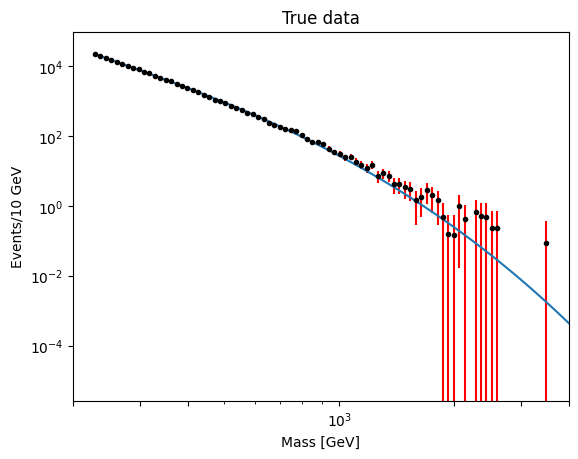

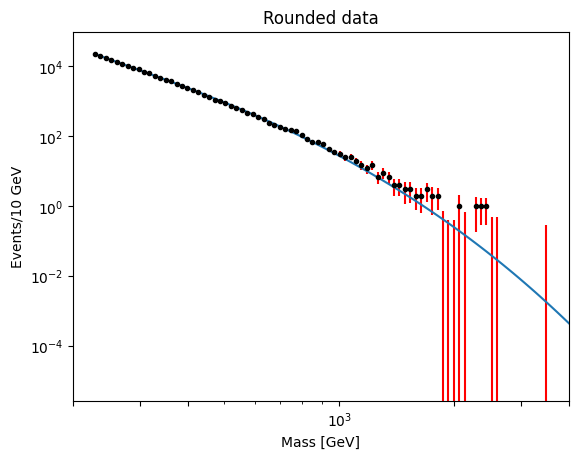

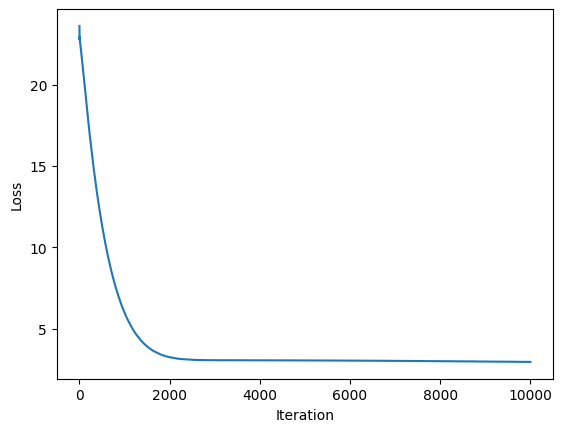

In [38]:
### Sped up version of class but now for fixd abp0

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p2_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95], high=[1.9 * 10**5, 5, -11.5, -4, -0.45])

    def curve_torch_2(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_2(self, y_pred_2):
        loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_2

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_2 = self.adjust_theta_2(y_pred_2)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 10000
            loss_crit = 1.5
            loss_filter = 3.1
            N_iter_filter = 4000
            N_iter = 0

            while N_iter < max_N:
                if N_iter == 0:
                    print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_2 = self.curve_torch_2(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_2, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            plt.plot(De_mass, y_pred_2_plot)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 4000)
            plt.ylim(top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            plt.title("True data")
            plt.show()

            plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            y_pred_2_plot = self.curve_torch_2(self.x_tensor, *theta_final).detach().numpy()
            plt.plot(De_mass, y_pred_2_plot)
            plt.yscale("log")
            plt.xscale("log")
            plt.xlabel("Mass [GeV]")
            plt.ylabel("Events/10 GeV")
            plt.xlim(200, 4000)
            plt.ylim(top=10**5)
            plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            plt.title("Rounded data")

            f_loss,a_loss = plt.subplots()
            a_loss.plot(losses)
            # a_loss.set_yscale("log")
            a_loss.set_ylabel("Loss")
            a_loss.set_xlabel("Iteration")
            # a_loss.set_xlim(N_iter-1000, N_iter)
            # a_loss.set_ylim(0.55, 0.6)


# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

optimizer_class = optim_p2_poisson(data_path)
optimizer_class.run()

## i = 3 model:

In [6]:
### Sped up version of class but now for fixd abp0

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)


# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

for j in range(5):
    losses_to_avg = []
    for i in range (60):
        optimizer_class = optim_p3_poisson(data_path)
        optimizer_class.run()

        losses_array = optimizer_class.losses
        final_loss = losses_array[-1]
        losses_to_avg.append(final_loss)
    print(f"Average loss = {np.mean(losses_to_avg)}")

Average loss = 2.674827814102173
Average loss = 2.673250913619995
Average loss = 2.673316240310669
Average loss = 2.6717371940612793
Average loss = 2.6740660667419434


## i = 4 model

In [7]:
### Sped up version of class but now for fixd abp0

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p4_poisson:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04, -0.001])

    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            N_iter_filter = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter_filter = 1000
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == N_iter_filter and loss > loss_filter:
                    # print(f"Final loss before filter = {losses[-1]}")
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:
            
            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)

            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_4_plot = self.curve_torch_4(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_4_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)


# Usage
data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'

for j in range(5):
    losses_to_avg = []
    for i in range (60):
        optimizer_class = optim_p4_poisson(data_path)
        optimizer_class.run()

        losses_array = optimizer_class.losses
        final_loss = losses_array[-1]
        losses_to_avg.append(final_loss)
    print(f"Average loss = {np.mean(losses_to_avg)}")

Average loss = 2.6764090061187744
Average loss = 2.678640604019165
Average loss = 2.6996676921844482
Average loss = 2.7210114002227783
Average loss = 2.6868937015533447


Once deciced which model is better we can use this to compare different ranges of b using the neural network binary classifier

## Comparing different ranges of b

### b 1 to 5 vs 5 to 10

In [9]:
class optim_p3_poisson_b_1to5:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

class optim_p3_poisson_b_5to10:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 5, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 10, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

for k in range(5):

    # Usage
    N = 5 * 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson_b_1to5(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_b1to5 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        # y_pred_3_rvs_priors_noise = 0
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_noise = torch.poisson(y_pred_3_rvs_priors)
        y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_b1to5.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    optimizer_class = optim_p3_poisson_b_5to10(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_b5to10 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        # y_pred_3_rvs_priors_noise = 0
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_noise = torch.poisson(y_pred_3_rvs_priors)
        y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_b5to10.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_b1to5)
    D4 = np.array(array_vector_datasets_b5to10)

    X = x_me

    print(f"Bayes factors for same datasets but different training rounds. Dataset {k}:")

    for j in range(5):

        evidence_network = BinaryClassifierLPop(len(X))

        data = np.concatenate((D3, D4))
        labels = np.concatenate((np.zeros(N), np.ones(N)))

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Bayes factors for same datasets but different training rounds. Dataset 0:
Using device:  cpu
Epoch 1/10, Loss: 0.7874407172203064
Epoch 2/10, Loss: 0.7063353657722473
Epoch 3/10, Loss: 0.6667538285255432
Epoch 4/10, Loss: 0.6515924334526062
Epoch 5/10, Loss: 1.0309494733810425
Epoch 6/10, Loss: 0.6776395440101624
Epoch 7/10, Loss: 0.6413021087646484
Epoch 8/10, Loss: 0.6401856541633606
Epoch 9/10, Loss: 0.6174556612968445
Epoch 10/10, Loss: 0.6105436086654663
Bayes Factor = 0.13893525302410126
Using device:  cpu
Epoch 1/10, Loss: 0.7545756101608276
Epoch 2/10, Loss: 0.6966110467910767
Epoch 3/10, Loss: 0.6690272688865662
Epoch 4/10, Loss: 0.6518952250480652
Epoch 5/10, Loss: 0.6459177732467651
Epoch 6/10, Loss: 0.6387385725975037
Epoch 7/10, Loss: 0.6565598845481873
Epoch 8/10, Loss: 0.627869188785553
Epoch 9/10, Loss: 0.6337372660636902
Epoch 10/10, Loss: 0.6212455034255981
Bayes Factor = 0.19885565340518951
Using device:  cpu
Epoch 1/10, Loss: 0.

### b 1 to 3 vs 3 to 5

In [6]:
class optim_p3_poisson_b_1to3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 3, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

class optim_p3_poisson_b_3to5:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 3, -13.5, -5.2, -0.95, -0.1], high=[1.9 * 10**5, 5, -11, -3.5, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        # y = y.round()
        return nn.PoissonNLLLoss(log_input=False, full=True)(y_pred, y)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1400
            loss_crit = 1.5
            loss_filter = 2.7
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
                # if N_iter == 1000 and loss < loss_filter:
                #     print(f"Loss at 1000 iterations = {loss}")
                # if N_iter == 1500 and loss < loss_filter:
                #     print(f"Loss at 1500 iterations = {loss}")
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success == True:

            self.losses = np.array(losses)

            theta_final = []

            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
            
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
        
            # print(f"Final theta = {self.theta_final}, Final loss = {losses[-1]}, Number of iterations = {N_iter}")
            
            # # Save results if good

            # timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
            # filename_theta_initial = f"Theta_3_initial_{timestamp}.txt"
            # filename_theta_final = f"Theta_3_final_{timestamp}.txt"

            # with open(filename_theta_initial, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))
            # with open(filename_theta_final, 'w') as f:
            #     f.write(str(self.theta_final.tolist()))

            # #Save figures
            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = curve_torch_3(x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])

            # filename_fig = f"Fig_3_{timestamp}.pdf"
            # plt.savefig(filename_fig)
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")

            # filename_figloss = f"Fig_3_loss_{timestamp}.pdf"
            # f_loss.savefig(filename_figloss, bbox_inches="tight")




            # # Plot results

            # plt.errorbar(De_mass, De_event, yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("True data")
            # plt.show()

            # plt.errorbar(De_mass, De_event.round(), yerr=yerr, fmt='.', color='black', ecolor='red')
            # y_pred_3_plot = self.curve_torch_3(self.x_tensor, *theta_final).detach().numpy()
            # plt.plot(De_mass, y_pred_3_plot)
            # plt.yscale("log")
            # plt.xscale("log")
            # plt.xlabel("Mass [GeV]")
            # plt.ylabel("Events/10 GeV")
            # plt.xlim(200, 4000)
            # plt.ylim(top=10**5)
            # plt.xticks([200, 300, 400, 1000, 2000, 3000, 4000])
            # plt.title("Rounded data")
            # plt.show()

            # f_loss,a_loss = plt.subplots()
            # a_loss.plot(losses)
            # # a_loss.set_yscale("log")
            # a_loss.set_ylabel("Loss")
            # a_loss.set_xlabel("Iteration")
            # # a_loss.set_xlim(N_iter-1000, N_iter)
            # # a_loss.set_ylim(0.55, 0.6)

for k in range(5):

    # Usage
    N = 5 * 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3_poisson_b_1to3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_b1to3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        # y_pred_3_rvs_priors_noise = 0
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_noise = torch.poisson(y_pred_3_rvs_priors)
        y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_b1to3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    optimizer_class = optim_p3_poisson_b_3to5(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_b3to5 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        # y_pred_3_rvs_priors_noise = 0
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_noise = torch.poisson(y_pred_3_rvs_priors)
        y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_b3to5.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_b1to3)
    D4 = np.array(array_vector_datasets_b3to5)

    X = x_me

    print(f"Bayes factors for same datasets but different training rounds. Dataset {k}:")

    for j in range(5):

        evidence_network = BinaryClassifierLPop(len(X))

        data = np.concatenate((D3, D4))
        labels = np.concatenate((np.zeros(N), np.ones(N)))

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Bayes factors for same datasets but different training rounds. Dataset 0:
Using device:  cpu
Epoch 1/10, Loss: 0.8812384009361267
Epoch 2/10, Loss: 0.8212120532989502
Epoch 3/10, Loss: 0.804573118686676
Epoch 4/10, Loss: 0.7939203381538391
Epoch 5/10, Loss: 0.7845296859741211
Epoch 6/10, Loss: 0.7794331908226013
Epoch 7/10, Loss: 0.7738037109375
Epoch 8/10, Loss: 0.7699363231658936
Epoch 9/10, Loss: 0.7658065557479858
Epoch 10/10, Loss: 0.7634832859039307
Bayes Factor = 0.12044312059879303
Using device:  cpu
Epoch 1/10, Loss: 0.9025015234947205
Epoch 2/10, Loss: 0.8359704613685608
Epoch 3/10, Loss: 0.8160631060600281
Epoch 4/10, Loss: 0.8018631339073181
Epoch 5/10, Loss: 0.8084020614624023
Epoch 6/10, Loss: 0.7859963178634644
Epoch 7/10, Loss: 0.7801878452301025
Epoch 8/10, Loss: 0.7725146412849426
Epoch 9/10, Loss: 0.766882598400116
Epoch 10/10, Loss: 0.7645954489707947
Bayes Factor = 0.4062904715538025
Using device:  cpu
Epoch 1/10, Loss: 0.88842

# Blind coverage tests

## Using i = 3 as test data

In [8]:
def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 1.5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

            if success == True:

                theta_final = []

                for i in range(len(theta_opt)):
                    theta_final.append(theta_opt[i])
            
                self.theta_final = torch.tensor(theta_final, dtype=torch.float32)          

class optim_p4:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04, -0.001])
    
    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 500 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            print(theta_final)

for k in range(1):

    # Usage
    N = 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        # y_pred_3_rvs_priors_noise = 0
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        # y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p4(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_4 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_4_rvs_priors = optimizer_class.curve_torch_4(x_tensor, *theta)
        # y_pred_4_rvs_priors_noise = 0  
        y_pred_4_rvs_priors_plus_noise = torch.poisson(y_pred_4_rvs_priors)
        # y_pred_4_rvs_priors_plus_noise = y_pred_4_rvs_priors + y_pred_4_rvs_priors_noise
        array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_3)
    D4 = np.array(array_vector_datasets_4)

    # Produce test data from i = 3 model
    optimizer_class = optim_p3(data_path)
    theta = optimizer_class.create_priors()
    test_data_3 = optimizer_class.curve_torch_3(x_tensor, *theta)
    test_data_3_plus_noise = torch.poisson(test_data_3)
    # test_data_plus_noise_3 = test_data_3 + test_noise_3

    X = x_me

    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            # Setting custom batch size and number of epochs
            # kwargs['batch_size'] = 1024 # Custom batch size
            kwargs['num_epochs'] = 30  # Custom number of epochs
            super().fit(X, y, **kwargs)
    
    # internal = 32
    # initial = 130

    evidence_network = CustomBinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D4))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    for j in range(3):

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(test_data_3_plus_noise[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.8730891942977905
Epoch 2/30, Loss: 0.8338177800178528
Epoch 3/30, Loss: 0.8191092014312744
Epoch 4/30, Loss: 0.8071860074996948
Epoch 5/30, Loss: 0.799302339553833
Epoch 6/30, Loss: 0.7879489660263062
Epoch 7/30, Loss: 0.7836686968803406
Epoch 8/30, Loss: 0.7774302959442139
Epoch 9/30, Loss: 0.7729884386062622
Epoch 10/30, Loss: 0.8158130645751953
Epoch 11/30, Loss: 0.7722810506820679
Epoch 12/30, Loss: 0.7646564841270447
Epoch 13/30, Loss: 0.7697115540504456
Epoch 14/30, Loss: 0.7577459812164307
Epoch 15/30, Loss: 0.7552767395973206
Epoch 16/30, Loss: 0.7518795728683472
Epoch 17/30, Loss: 0.7499002814292908
Epoch 18/30, Loss: 0.7467005252838135
Epoch 19/30, Loss: 0.7480288147926331
Epoch 20/30, Loss: 0.7396911382675171
Epoch 21/30, Loss: 0.7369897365570068
Epoch 22/30, Loss: 0.7372293472290039
Epoch 23/30, Loss: 0.7431078553199768
Epoch 24/30, Loss: 0.7363328337669373
Epoch 25/30, Loss: 0.7321476936340332
Epo

/opt/homebrew/lib/python3.11/site-packages/lsbi/network.py:193: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 1/30, Loss: 0.8139814138412476
Epoch 2/30, Loss: 0.7917852997779846
Epoch 3/30, Loss: 0.79770427942276
Epoch 4/30, Loss: 0.8056045770645142
Epoch 5/30, Loss: 0.7802413105964661
Epoch 6/30, Loss: 0.7974674701690674
Epoch 7/30, Loss: 0.7722417712211609
Epoch 8/30, Loss: 0.7713688015937805
Epoch 9/30, Loss: 0.7687605023384094
Epoch 10/30, Loss: 0.7572773694992065
Epoch 11/30, Loss: 0.7691084146499634
Epoch 12/30, Loss: 0.7499680519104004
Epoch 13/30, Loss: 0.7477287650108337
Epoch 14/30, Loss: 0.7508612871170044
Epoch 15/30, Loss: 0.7546026706695557
Epoch 16/30, Loss: 0.7502614259719849
Epoch 17/30, Loss: 0.7651844620704651
Epoch 18/30, Loss: 0.733859121799469
Epoch 19/30, Loss: 0.7328646183013916
Epoch 20/30, Loss: 0.735054075717926
Epoch 21/30, Loss: 0.7269188761711121
Epoch 22/30, Loss: 0.7284637093544006
Epoch 23/30, Loss: 0.7245337963104248
Epoch 24/30, Loss: 0.7251800298690796
Epoch 25/30, Loss: 0.7225319147109985
Epoch 26/30, Loss: 0.7190725803375244
Epoch 27/30, Loss: 0.7174

## Using i = 4 as test data

In [7]:
def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 1.5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

            if success == True:

                theta_final = []

                for i in range(len(theta_opt)):
                    theta_final.append(theta_opt[i])
            
                self.theta_final = torch.tensor(theta_final, dtype=torch.float32)          

class optim_p4:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x_me = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x_me, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1, -0.006], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04, -0.001])
    
    def curve_torch_4(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft, p4_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3 + p4_ft * log_x ** 4)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_4(self, y_pred_4):
        loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_4

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)

            y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_4 = self.adjust_theta_4(y_pred_4)
            else:
                pass
            #     # print("Valid start point found.")

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                #     print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_4 = self.curve_torch_4(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_4, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 500 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

        if success:

            theta_final = []
        
            for i in range(len(theta_opt)):
                theta_final.append(theta_opt[i])
        
            self.theta_final = torch.tensor(theta_final, dtype=torch.float32)
            print(theta_final)

for k in range(1):

    # Usage
    N = 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        # y_pred_3_rvs_priors_noise = 0
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        # y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Usage
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p4(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_4 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_4_rvs_priors = optimizer_class.curve_torch_4(x_tensor, *theta)
        # y_pred_4_rvs_priors_noise = 0  
        y_pred_4_rvs_priors_plus_noise = torch.poisson(y_pred_4_rvs_priors)
        # y_pred_4_rvs_priors_plus_noise = y_pred_4_rvs_priors + y_pred_4_rvs_priors_noise
        array_vector_datasets_4.append(y_pred_4_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Produce test data from i = 3 model
    optimizer_class = optim_p4(data_path)
    theta = optimizer_class.create_priors()
    test_data_4 = optimizer_class.curve_torch_4(x_tensor, *theta)
    test_data_4_plus_noise = torch.poisson(test_data_4)
    # test_data_plus_noise_4 = test_data_4 + test_noise_4

    D3 = np.array(array_vector_datasets_3)
    D4 = np.array(array_vector_datasets_4)

    X = x_me

    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            # Setting custom batch size and number of epochs
            # kwargs['batch_size'] = 128  # Custom batch size
            kwargs['num_epochs'] = 30  # Custom number of epochs
            super().fit(X, y, **kwargs)

    evidence_network = CustomBinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D4))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    for j in range(3):
        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(test_data_4_plus_noise[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

Datasets simulated
Datasets simulated
Using device:  cpu
Epoch 1/30, Loss: 0.8717136979103088
Epoch 2/30, Loss: 0.8359814882278442
Epoch 3/30, Loss: 0.8270525336265564
Epoch 4/30, Loss: 0.8091176152229309
Epoch 5/30, Loss: 0.7928028106689453
Epoch 6/30, Loss: 0.7843102216720581
Epoch 7/30, Loss: 0.8036034107208252
Epoch 8/30, Loss: 0.7966336011886597
Epoch 9/30, Loss: 0.7763996124267578
Epoch 10/30, Loss: 0.7717043161392212
Epoch 11/30, Loss: 0.7674100399017334
Epoch 12/30, Loss: 0.7646190524101257
Epoch 13/30, Loss: 0.7661556601524353
Epoch 14/30, Loss: 0.7557851076126099
Epoch 15/30, Loss: 0.7537419199943542
Epoch 16/30, Loss: 0.7526283860206604
Epoch 17/30, Loss: 0.7476561665534973
Epoch 18/30, Loss: 0.7453693747520447
Epoch 19/30, Loss: 0.7531836628913879
Epoch 20/30, Loss: 0.7488125562667847
Epoch 21/30, Loss: 0.7427161335945129
Epoch 22/30, Loss: 0.7389727234840393
Epoch 23/30, Loss: 0.7336698174476624
Epoch 24/30, Loss: 0.7359534502029419
Epoch 25/30, Loss: 0.7298495769500732
Ep

/opt/homebrew/lib/python3.11/site-packages/lsbi/network.py:193: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 1/30, Loss: 0.8160009980201721
Epoch 2/30, Loss: 0.8262876868247986
Epoch 3/30, Loss: 0.7872750163078308
Epoch 4/30, Loss: 0.7878836393356323
Epoch 5/30, Loss: 0.786086916923523
Epoch 6/30, Loss: 0.7701146006584167
Epoch 7/30, Loss: 0.7845614552497864
Epoch 8/30, Loss: 0.7818761467933655
Epoch 9/30, Loss: 0.7681846618652344
Epoch 10/30, Loss: 0.7566618323326111
Epoch 11/30, Loss: 0.7595372796058655
Epoch 12/30, Loss: 0.7444261312484741
Epoch 13/30, Loss: 0.7637259364128113
Epoch 14/30, Loss: 0.7635039687156677
Epoch 15/30, Loss: 0.7469671964645386
Epoch 16/30, Loss: 0.7384151220321655
Epoch 17/30, Loss: 0.7551414966583252
Epoch 18/30, Loss: 0.7340527772903442
Epoch 19/30, Loss: 0.7392693161964417
Epoch 20/30, Loss: 0.732367992401123
Epoch 21/30, Loss: 0.7270030379295349
Epoch 22/30, Loss: 0.7250018119812012
Epoch 23/30, Loss: 0.7203614115715027
Epoch 24/30, Loss: 0.7242087721824646
Epoch 25/30, Loss: 0.7159989476203918
Epoch 26/30, Loss: 0.7132415175437927
Epoch 27/30, Loss: 0.71

# Signal detection

A similar method is used to do signal detection instead this time we use a background only model and a background model plus a signal where we think there might be a bump and compare the models using the classifier. First I will do manual detection but this will be automated later to scan a given range and apply signal tests for a given width of signal in each range.

In [ ]:
# Using i = 3 model

def load_and_process_data(data_path):
    De = pd.read_csv(data_path, usecols=["Mass [GeV]", "Events/10 GeV"])
    De_mass = De["Mass [GeV]"].values
    De_event = De["Events/10 GeV"].values
    yerr = np.sqrt(De_event)
    return De_mass, De_event, yerr

class optim_p3:
    def __init__(self, data_path):
        self.gamma = 2.4952
        self.mz = 91.1876
        self.De_mass, self.De_event, self.yerr = load_and_process_data(data_path)
        self.x = self.De_mass / 13000
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.De_event, dtype=torch.float32)
        self.y_err_tensor = torch.tensor(self.yerr, dtype=torch.float32)
        self.c_e_ft = 1

    def create_priors(self):
        return np.random.uniform(low=[1.7 * 10**5, 1, -13.2, -4.75, -0.95, -0.1], high=[1.9 * 10**5, 5, -11.5, -4, -0.45, -0.04])

    def curve_torch_3(self, x, a_ft, b_ft, p0_ft, p1_ft, p2_ft, p3_ft):
        BW2 = self.gamma / ((x * 13000 - self.mz) ** 2 + (self.gamma ** 2) / 4)
        log_x = torch.log(x)
        curve_ft = BW2 * ((1 - x ** self.c_e_ft) ** b_ft) * x ** (p0_ft + p1_ft * log_x + p2_ft * log_x ** 2 + p3_ft * log_x ** 3)
        norm_ft = a_ft / curve_ft.sum()
        return norm_ft * curve_ft

    def loglike(self, y_pred, y, y_err_tensor):
        valid_indices = y_err_tensor > 0
        chi_sq = ((y_pred[valid_indices] - y[valid_indices]) ** 2) / (y_err_tensor[valid_indices] ** 2)
        return torch.mean(chi_sq)

    def threshold(self):
        return 25

    def adjust_theta_3(self, y_pred_3):
        loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        while not self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor) < self.threshold():
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
        return loss, theta_opt, y_pred_3

    def run(self):
        success = False

        while not success:
            priors = self.create_priors()
            theta_opt = []
            for i in range(len(priors)):
                theta_opt.append(torch.tensor(priors[i], dtype=torch.float32, requires_grad=True))
            theta_opt = torch.tensor(theta_opt, dtype=torch.float32, requires_grad=True)
            y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
            initial_loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)

            # print(f"First theta = {theta}")

            if initial_loss > self.threshold() and not torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            if torch.isnan(initial_loss):
                # print("Invalid loss, adjusting.")
                initial_loss, theta_opt, y_pred_3 = self.adjust_theta_3(y_pred_3)
            else:
                # print("Valid start point found.")
                pass

            optimizer = Adam([theta_opt], lr=0.001)
            loss = initial_loss
            losses = []
            max_N = 1000
            loss_crit = 1.5
            loss_filter = 5
            N_iter = 0

            while N_iter < max_N:
                # if N_iter == 0:
                    # print(f"Initial Loss = {loss}")
                optimizer.zero_grad()
                y_pred_3 = self.curve_torch_3(self.x_tensor, *theta_opt)
                loss = self.loglike(y_pred_3, self.y_tensor, self.y_err_tensor)
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().numpy())
                N_iter += 1
                # if loss < loss_crit:
                #     success = True
                #     break
                # if N_iter % 250 == 0:
                    # print(f"N_iter = {N_iter}")
                    # print(f"Loss = {loss}")
                if N_iter == 1000 and loss > loss_filter:
                    # print("Loss too high. Starting again.")
                    break
            # else:
                # print("Max number of iterations reach, no optimised value found. Starting again.")

            if N_iter == max_N:
                success = True

            if success == True:

                theta_final = []

                for i in range(len(theta_opt)):
                    theta_final.append(theta_opt[i])
            
                self.theta_final = torch.tensor(theta_final, dtype=torch.float32)          

for j in range(2):

    # Background only model
    N = 10**5
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3 = []
    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        y_pred_3_rvs_priors_plus_noise = torch.poisson(y_pred_3_rvs_priors)
        # y_pred_3_rvs_priors_plus_noise = y_pred_3_rvs_priors + y_pred_3_rvs_priors_noise
        array_vector_datasets_3.append(y_pred_3_rvs_priors_plus_noise.detach().numpy())

    print("Datasets simulated")

    # Background plus signal model
    data_path = '/Users/ptsandsway/github-classroom/Part-III-Project/De_data.csv'
    optimizer_class = optim_p3(data_path)
    x_tensor = optimizer_class.x_tensor
    array_vector_datasets_3_signal = []

    # For signal have so far chosen to have perceived width of signal to be equal to 2 sigma

    def gaussian_signal(x, mean, std_dev, amplitude):
        prefactor = amplitude / np.sqrt(2 * np.pi * std_dev**2)
        exponent = -((x - mean)**2) / (2 * std_dev**2)
        return prefactor * np.exp(exponent)

    for i in range(N):
        theta = optimizer_class.create_priors()
        y_pred_3_rvs_priors = optimizer_class.curve_torch_3(x_tensor, *theta)
        signal_x_range = x_tensor[(x_tensor >= 2000) & (x_tensor <= 2600)]
        signal = gaussian_signal(signal_x_range, mean = 2280, st_dev = 200, amplitude = 0.7)
        y_pred_3_rvs_priors_plus_signal = y_pred_3_rvs_priors + signal
        y_pred_3_rvs_priors_plus_signal_and_noise = torch.poisson(y_pred_3_rvs_priors_plus_signal)
        # y_pred_3_rvs_priors_plus_signal_and_noise = y_pred_3_rvs_priors_plus_signal + y_pred_3_rvs_priors_noise
        array_vector_datasets_3_signal.append(y_pred_3_rvs_priors_plus_signal_and_noise.detach().numpy())

    print("Datasets simulated")

    D3 = np.array(array_vector_datasets_3)
    D4 = np.array(array_vector_datasets_4)

    X = x_me

    class CustomBinaryClassifierLPop(BinaryClassifierLPop):
        def fit(self, X, y, **kwargs):
            # Setting custom batch size and number of epochs
            # kwargs['batch_size'] = 128 # Custom batch size
            kwargs['num_epochs'] = 30  # Custom number of epochs
            super().fit(X, y, **kwargs)
    
    # internal = 16
    # initial = 130

    evidence_network = CustomBinaryClassifierLPop(len(X))

    # evidence_network = BinaryClassifierLPop(len(X))

    data = np.concatenate((D3, D4))
    labels = np.concatenate((np.zeros(N), np.ones(N)))

    for k in range(3):

        evidence_network.fit(data, labels)

        log_K = evidence_network.predict(De_event[...,None].T).squeeze()
        print(f"Bayes Factor = {log_K}")

In [10]:
lam = torch.tensor([4.0] * 10)
samples = torch.poisson(lam)

print(samples)

tensor([ 8.,  3.,  2.,  4.,  3.,  3.,  5., 12.,  1.,  6.])
